<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback


In [31]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [32]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "SalesOneWeekAgo", "SalesTwoWeeksAgo", "SalesThreeWeeksAgo"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [33]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)
print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

Base original  --->  (6435, 67) (6435, 67) 
Base de Treino  --->  (4500, 63) (4500,) 
Base de teste   --->  (1935, 63)  (1935,)


In [34]:
X_train_list = X_train.values;
X_test_list = X_test.values;
y_train_list = y_train.copy();

# corte = int(len(X_train_list)*0.9)
# X_validation = X_train_list[corte:]
# X_train_list = X_train_list[:corte]
# y_validation = y_train_list[corte:]
# y_train_list = y_train_list[:corte]

In [35]:
# Define model
model = Sequential()
model.add(Dense(500, input_shape = (X_test.shape[1],), activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [36]:
history = model.fit(
        X_train_list,y_train_list,
        #validation_data =(X_validation, y_validation),
        validation_split = 0.10,
        epochs = 100
)

Epoch 1/100
127/127 [==============================] - 2s 8ms/step - loss: 1118469750784.0000 - mean_squared_error: 1118469750784.0000 - val_loss: 181529018368.0000 - val_mean_squared_error: 181529018368.0000
Epoch 2/100
127/127 [==============================] - 1s 6ms/step - loss: 405911535616.0000 - mean_squared_error: 405911535616.0000 - val_loss: 209740726272.0000 - val_mean_squared_error: 209740726272.0000
Epoch 3/100
127/127 [==============================] - 1s 6ms/step - loss: 401794826240.0000 - mean_squared_error: 401794826240.0000 - val_loss: 226288533504.0000 - val_mean_squared_error: 226288533504.0000
Epoch 4/100
127/127 [==============================] - 1s 6ms/step - loss: 396085526528.0000 - mean_squared_error: 396085526528.0000 - val_loss: 170633969664.0000 - val_mean_squared_error: 170633969664.0000
Epoch 5/100
127/127 [==============================] - 1s 7ms/step - loss: 392574992384.0000 - mean_squared_error: 392574992384.0000 - val_loss: 226218573824.0000 - val_m

In [37]:
predictions = model.predict(X_test_list)

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

61/61 [==============================] - 0s 2ms/step


(0.8967397627195302, 112826.445, 172404.36)

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 500)               32000     
                                                                 
 dense_11 (Dense)            (None, 250)               125250    
                                                                 
 dense_12 (Dense)            (None, 100)               25100     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 187,451
Trainable params: 187,451
Non-trainable params: 0
_________________________________________________________________


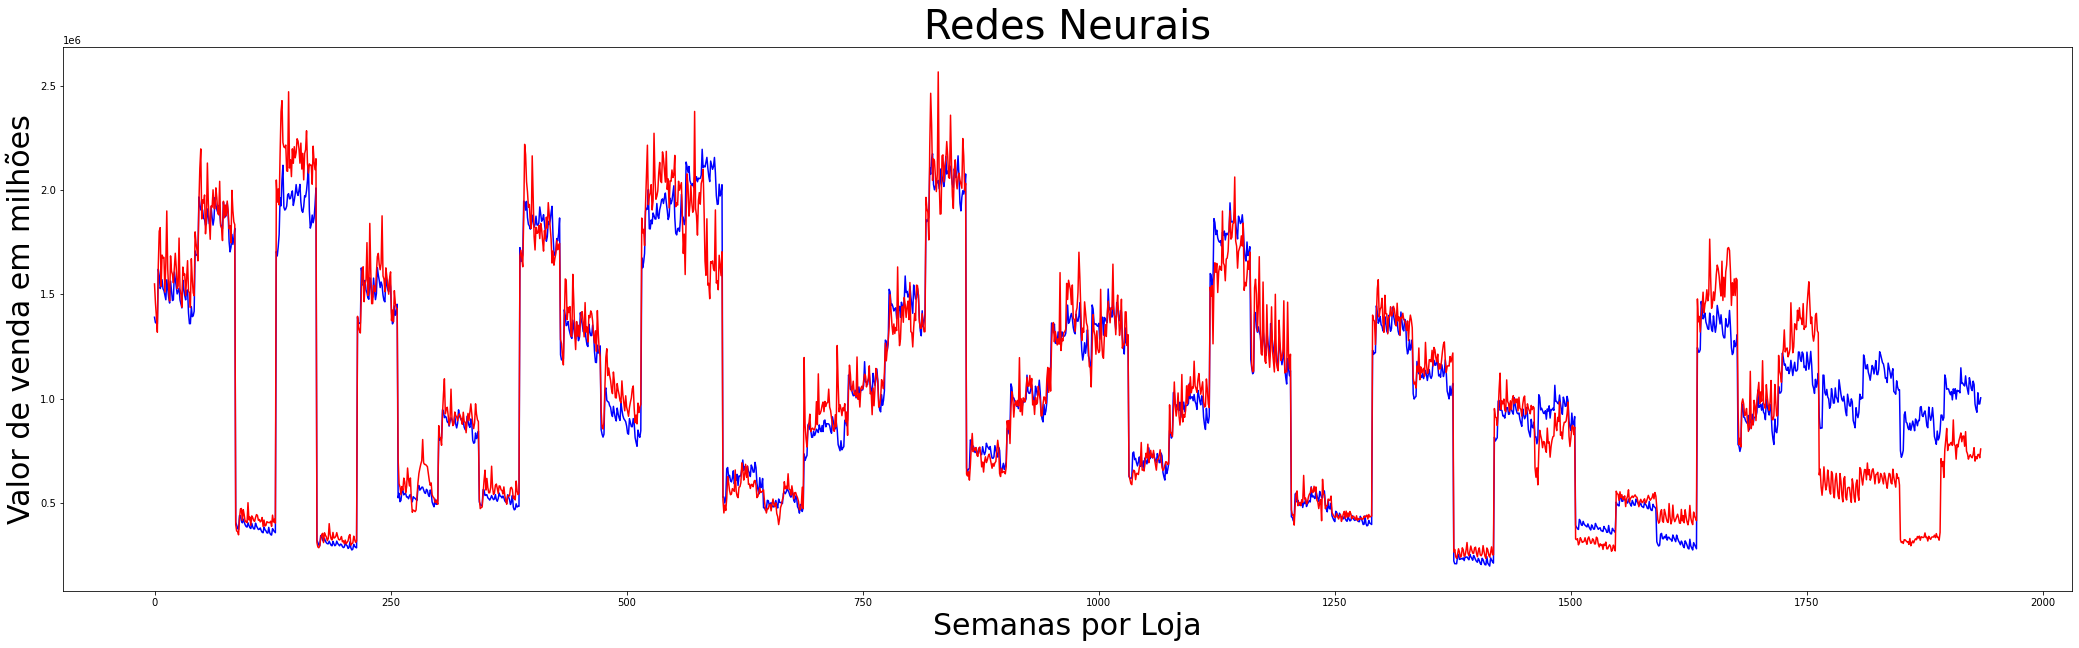

In [39]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Redes Neurais", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

2/2 [==============================] - 0s 7ms/step
Resultados Loja 1:
101258.79 127177.305


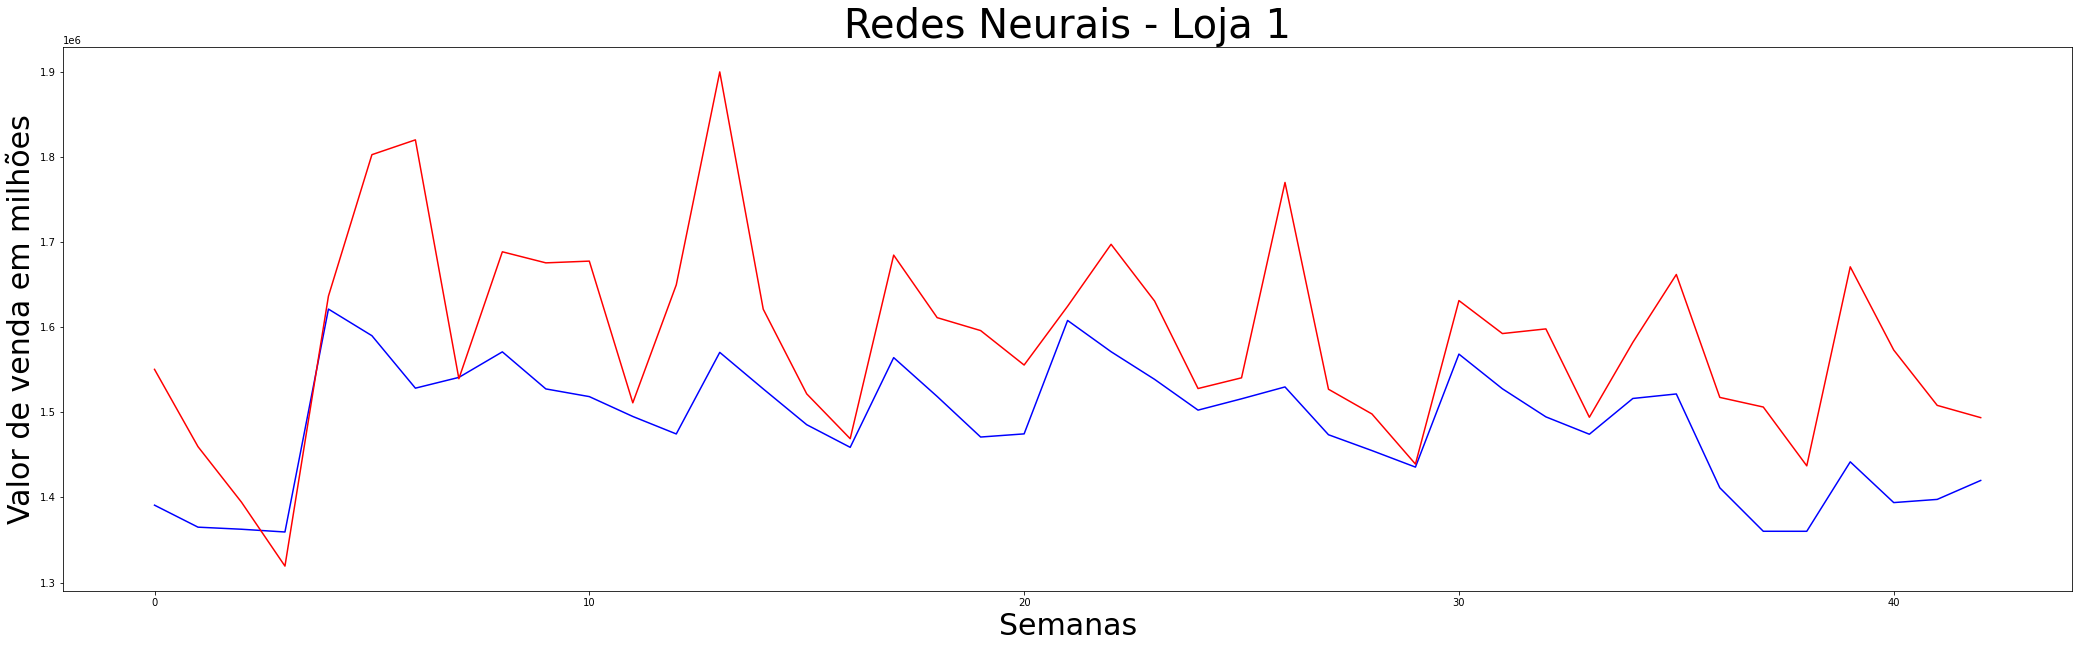

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 2:
68573.67 95006.23


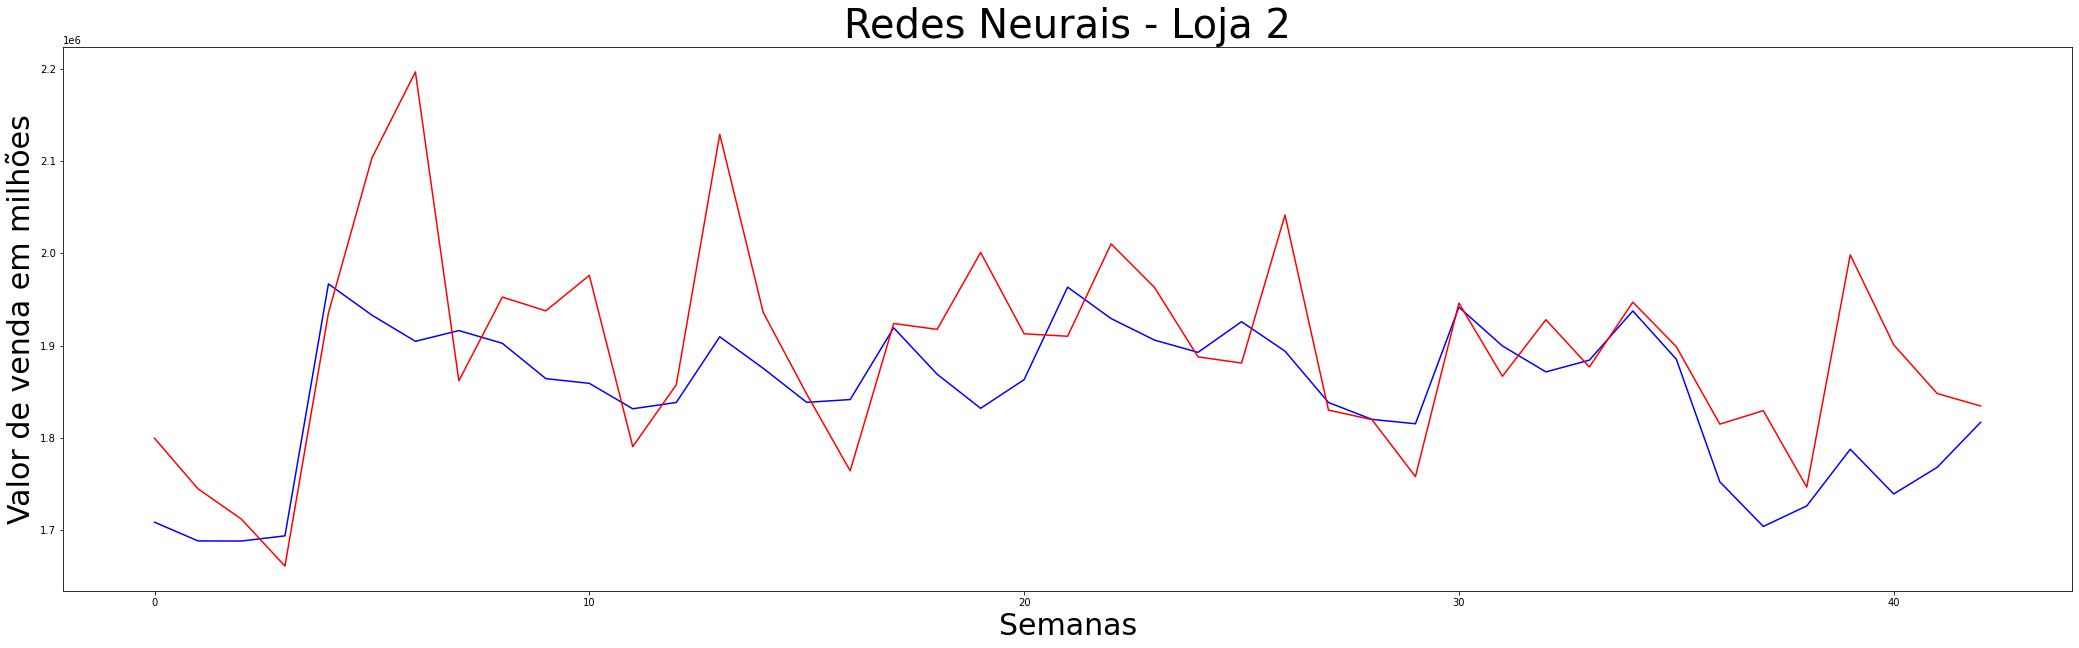

**************************************************
2/2 [==============================] - 0s 10ms/step
Resultados Loja 3:
38690.02 42657.5


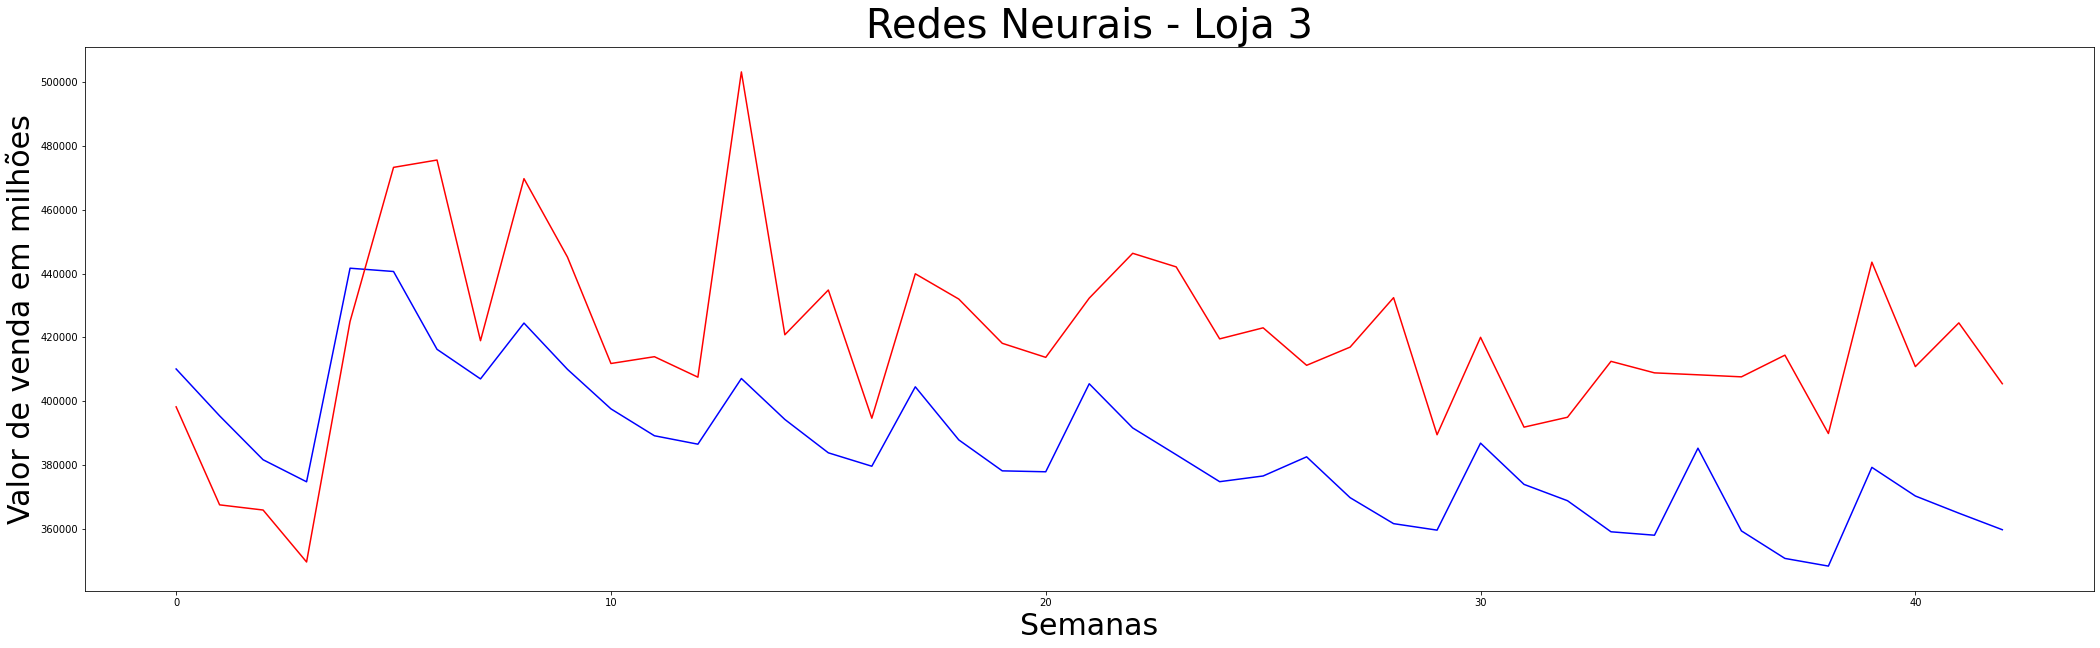

**************************************************
2/2 [==============================] - 0s 7ms/step
Resultados Loja 4:
225005.2 244576.89


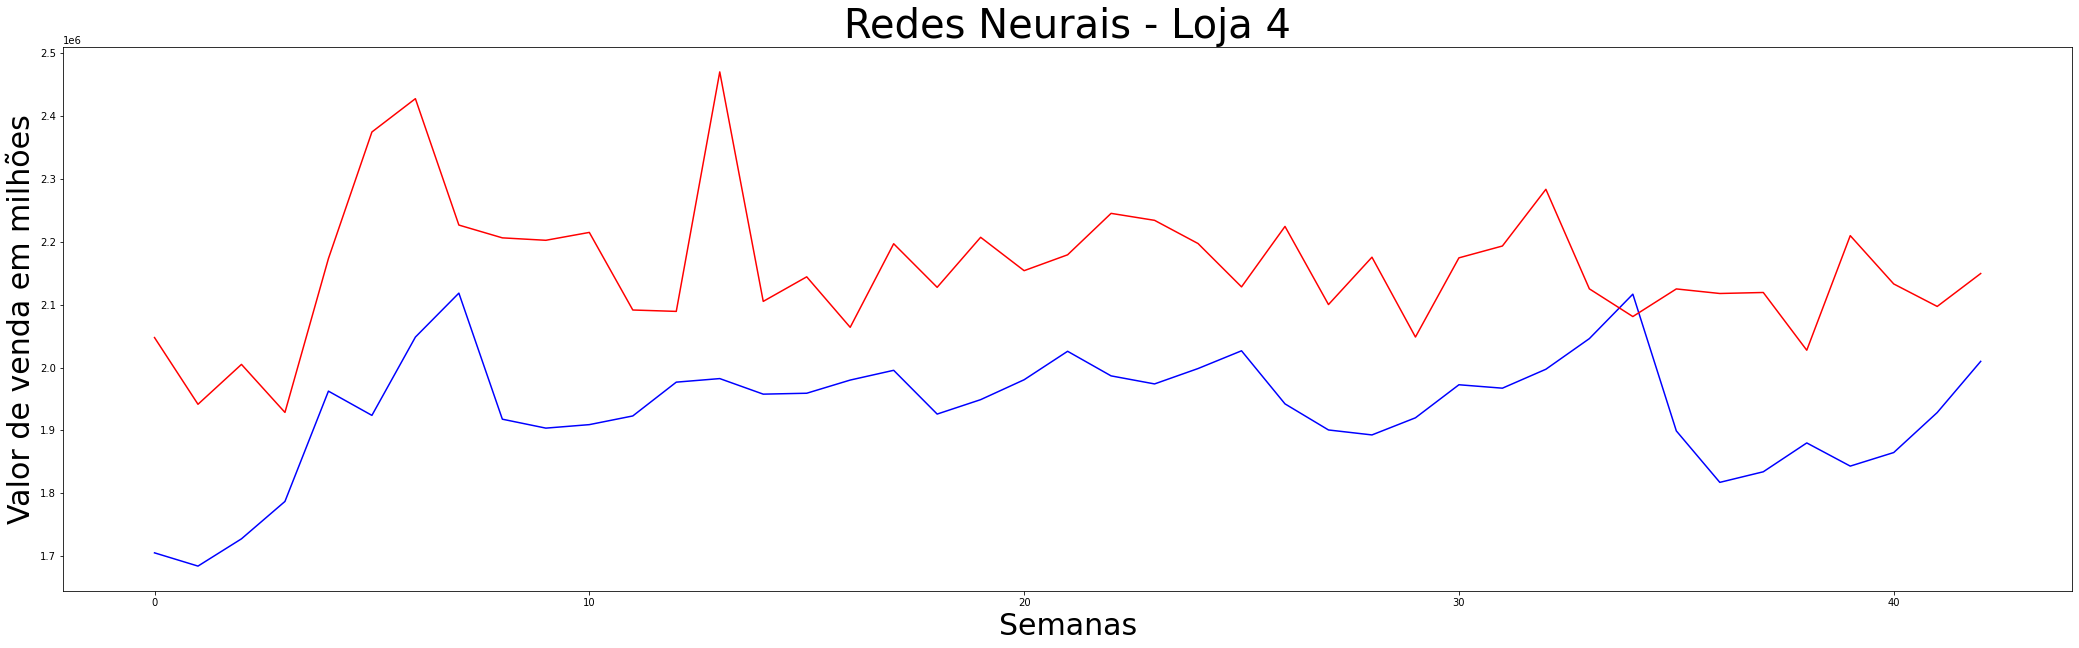

**************************************************
2/2 [==============================] - 0s 13ms/step
Resultados Loja 5:
27551.34 31212.154


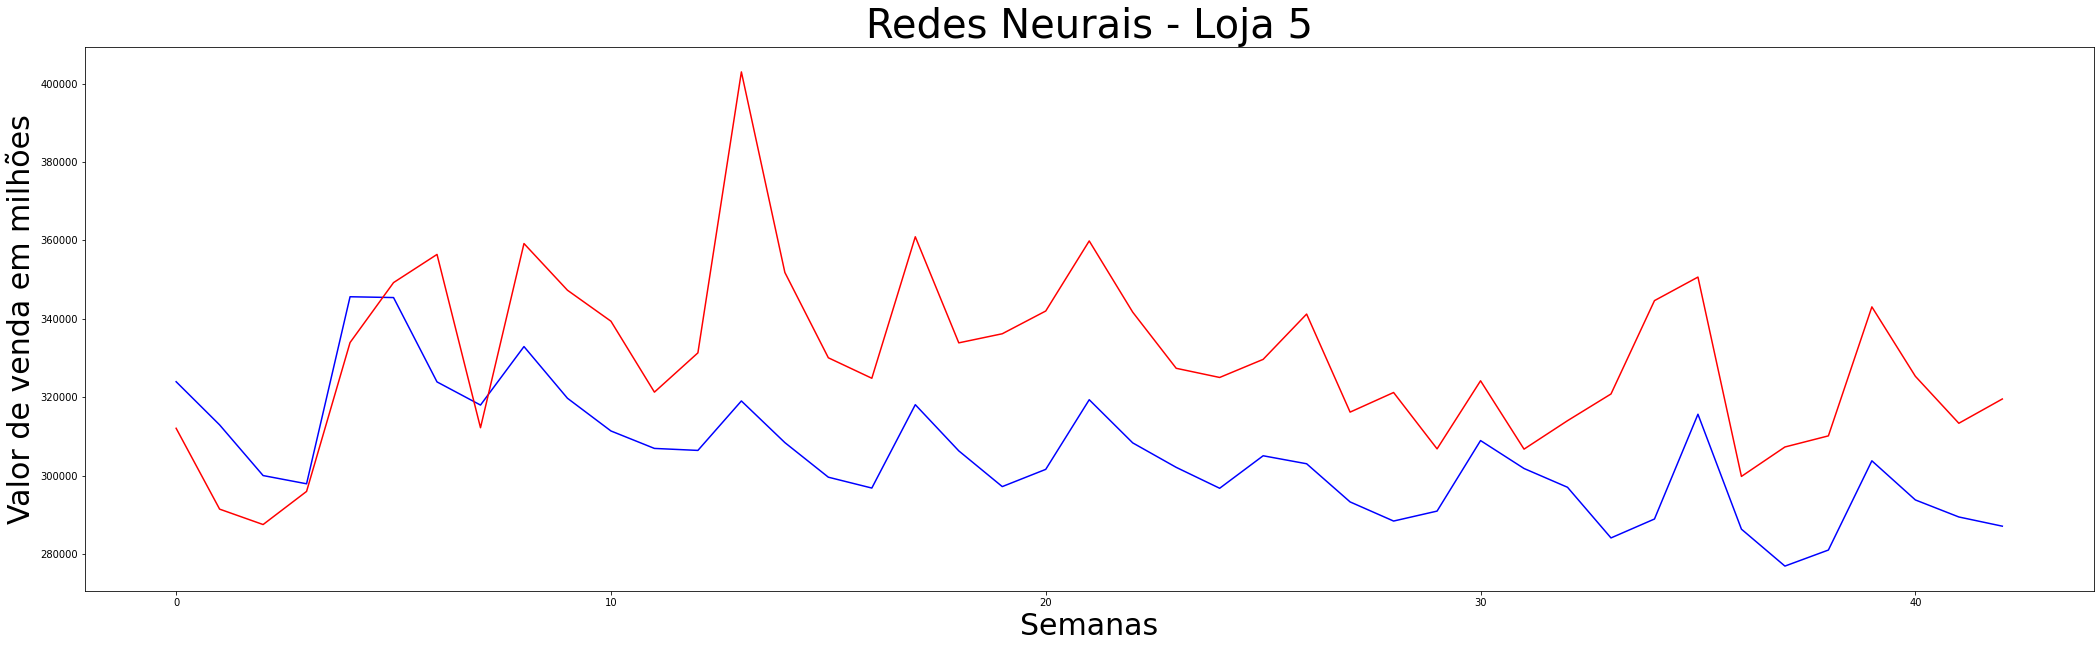

**************************************************
2/2 [==============================] - 0s 11ms/step
Resultados Loja 6:
65769.46 93874.87


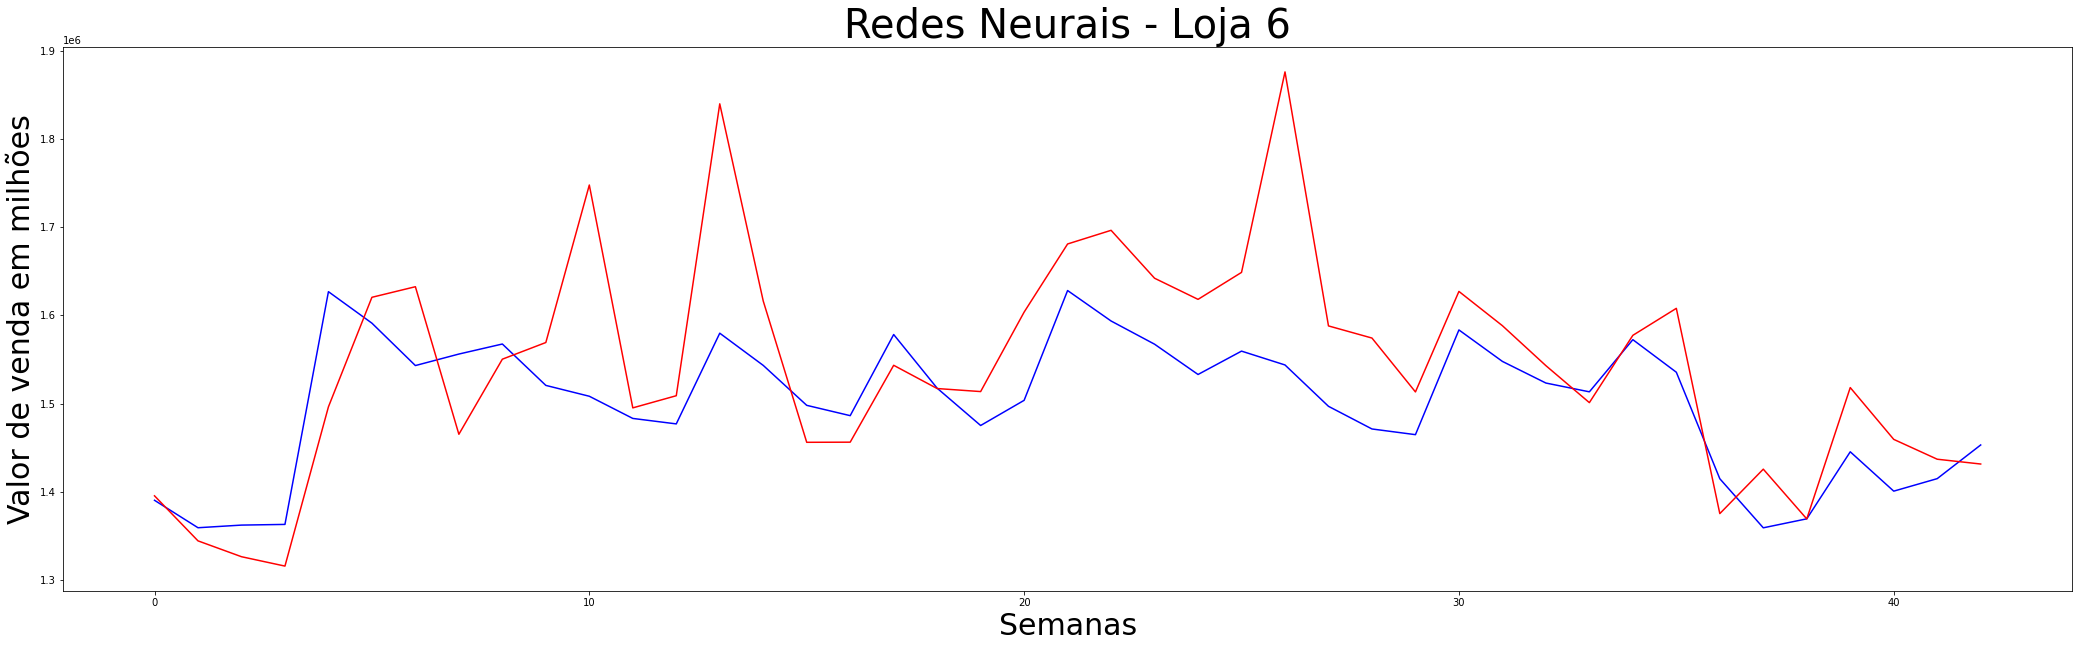

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 7:
67797.17 84856.414


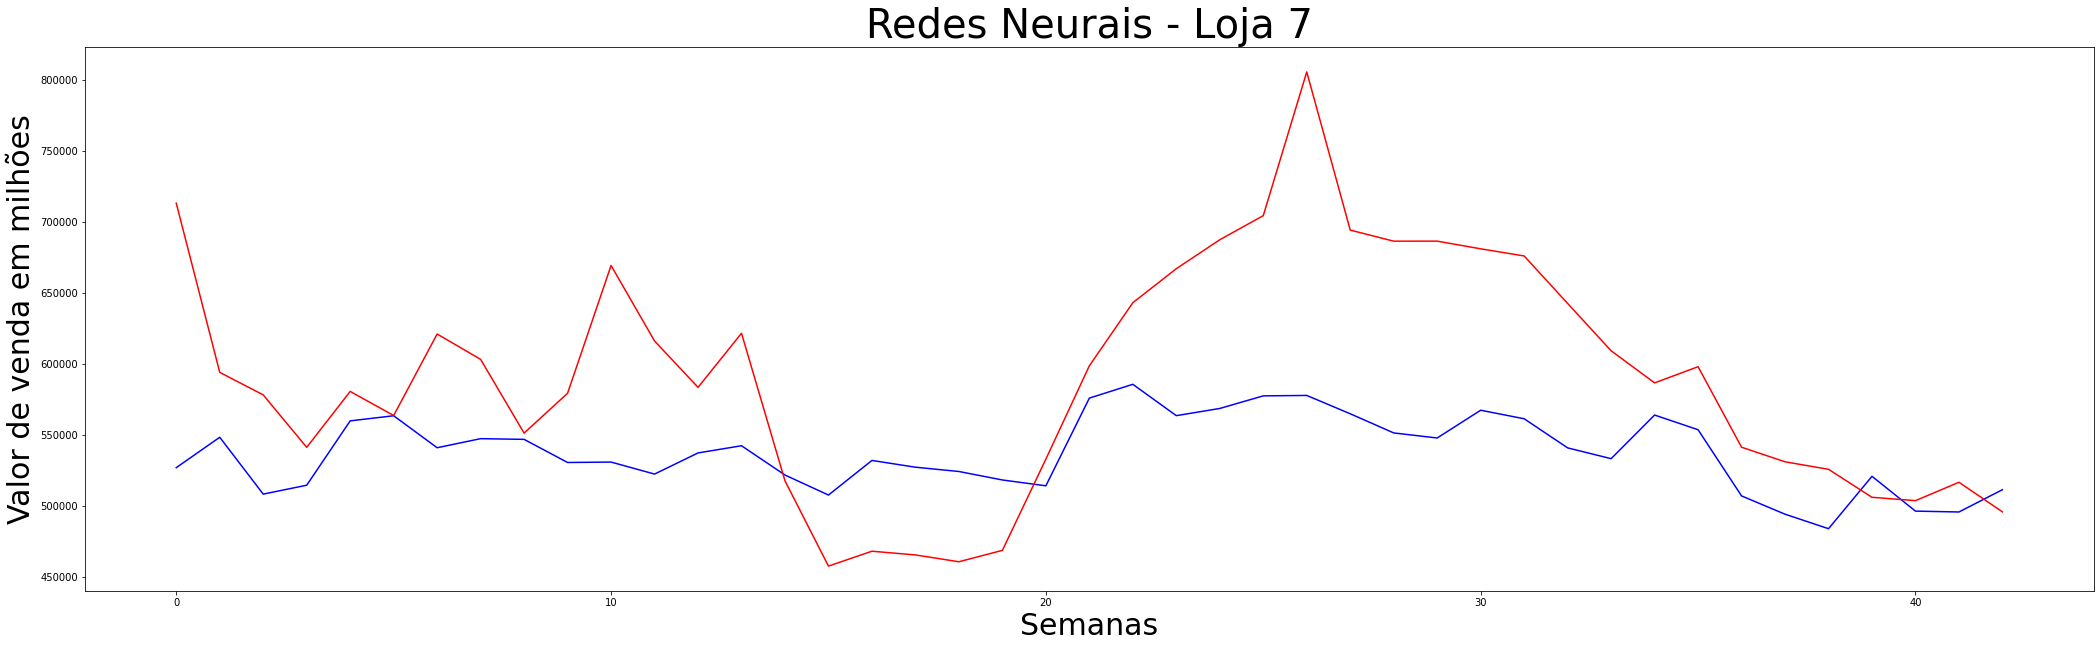

**************************************************
2/2 [==============================] - 0s 16ms/step
Resultados Loja 8:
44961.082 60902.562


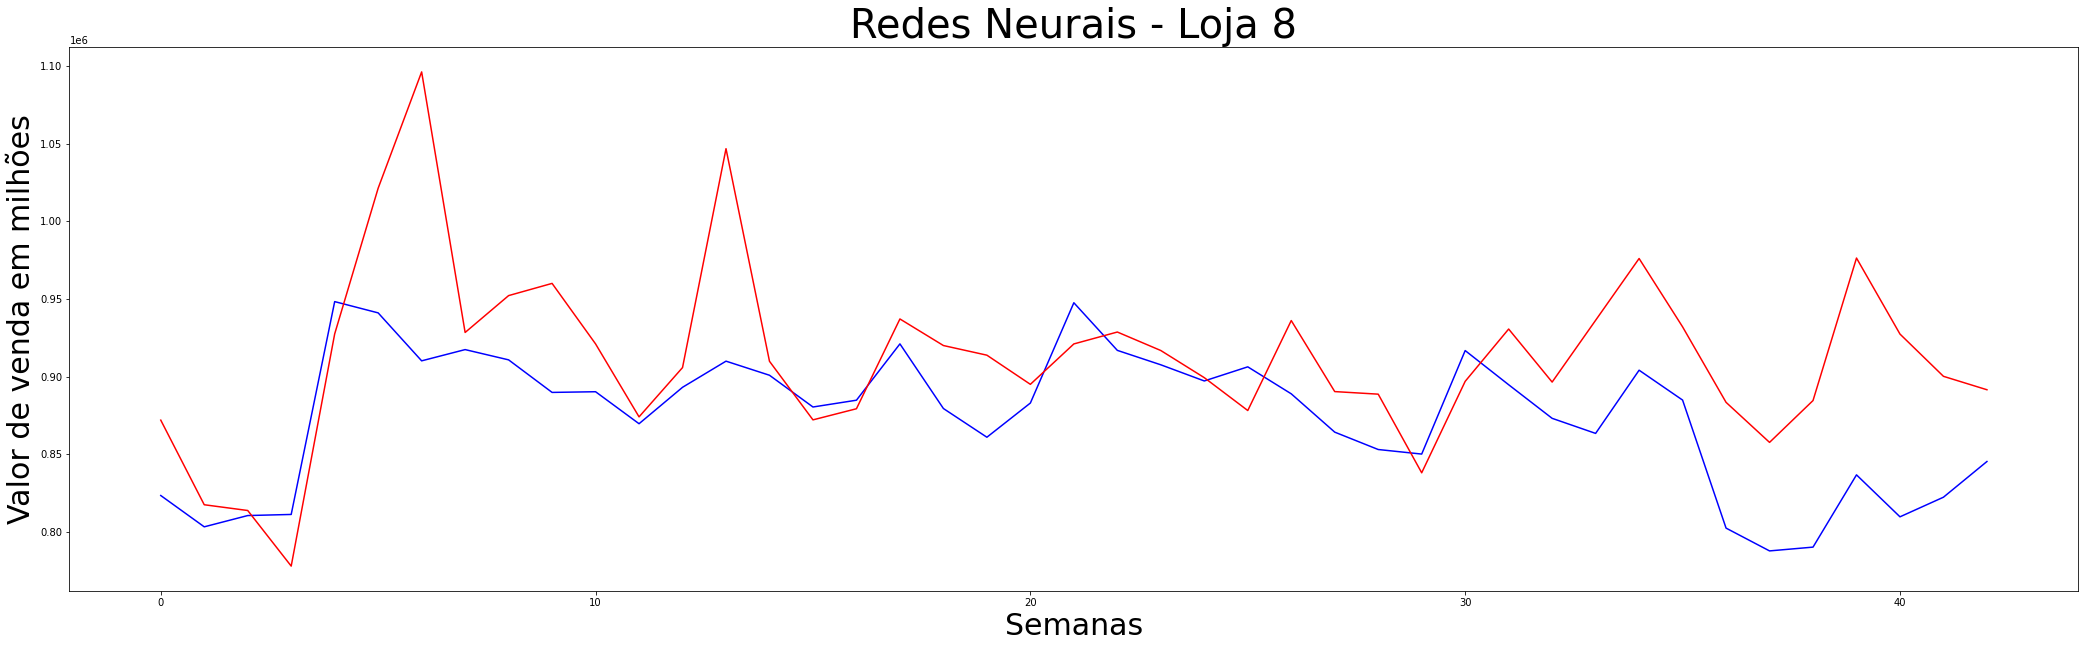

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 9:
43291.63 53051.613


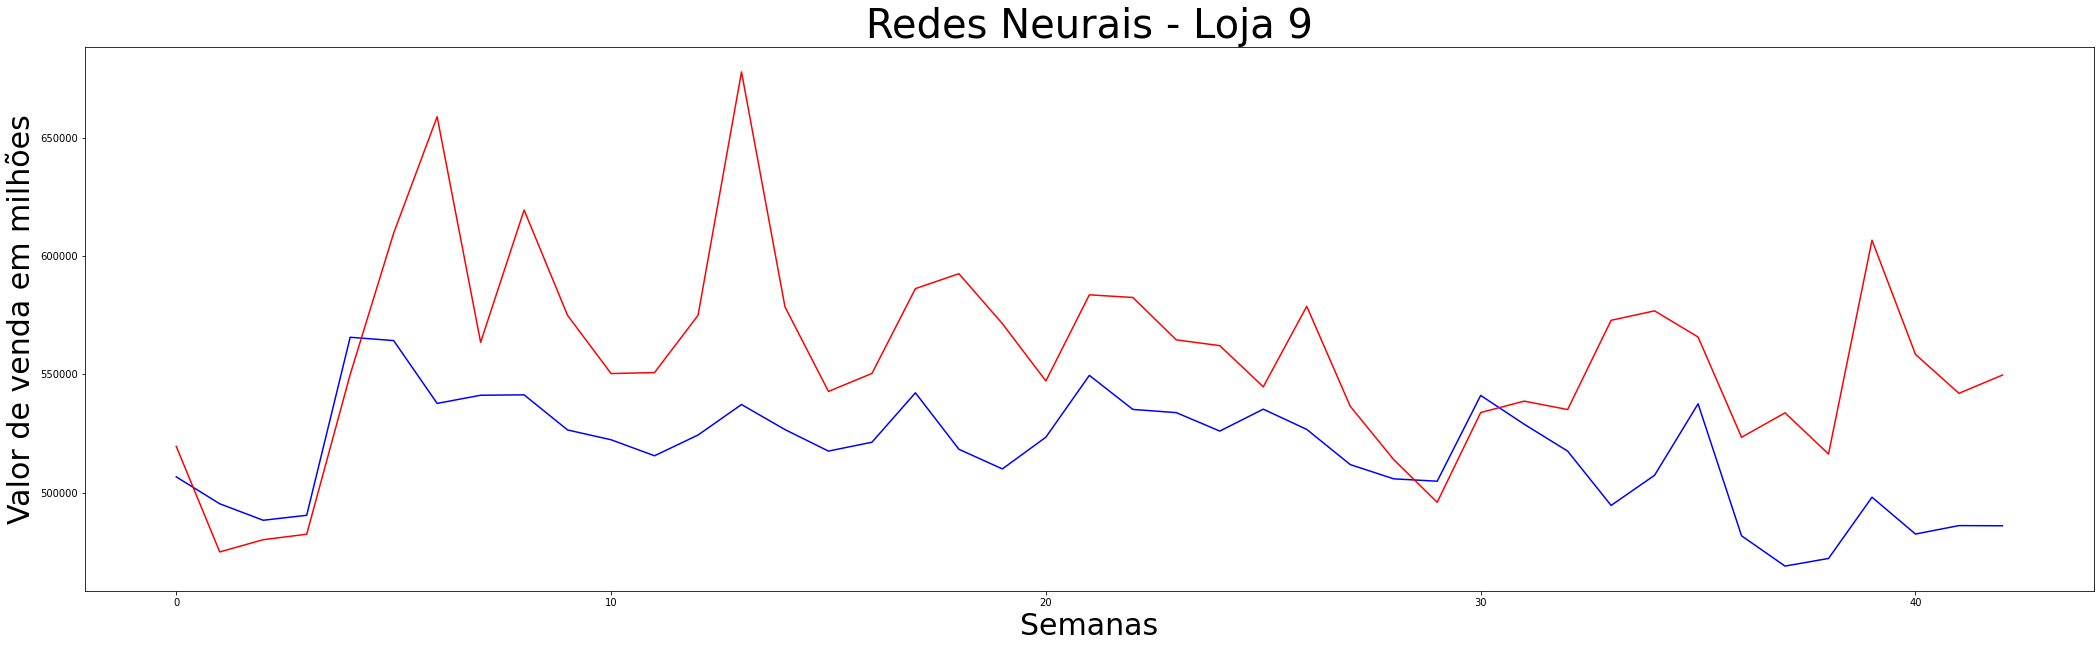

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 10:
84741.78 111940.984


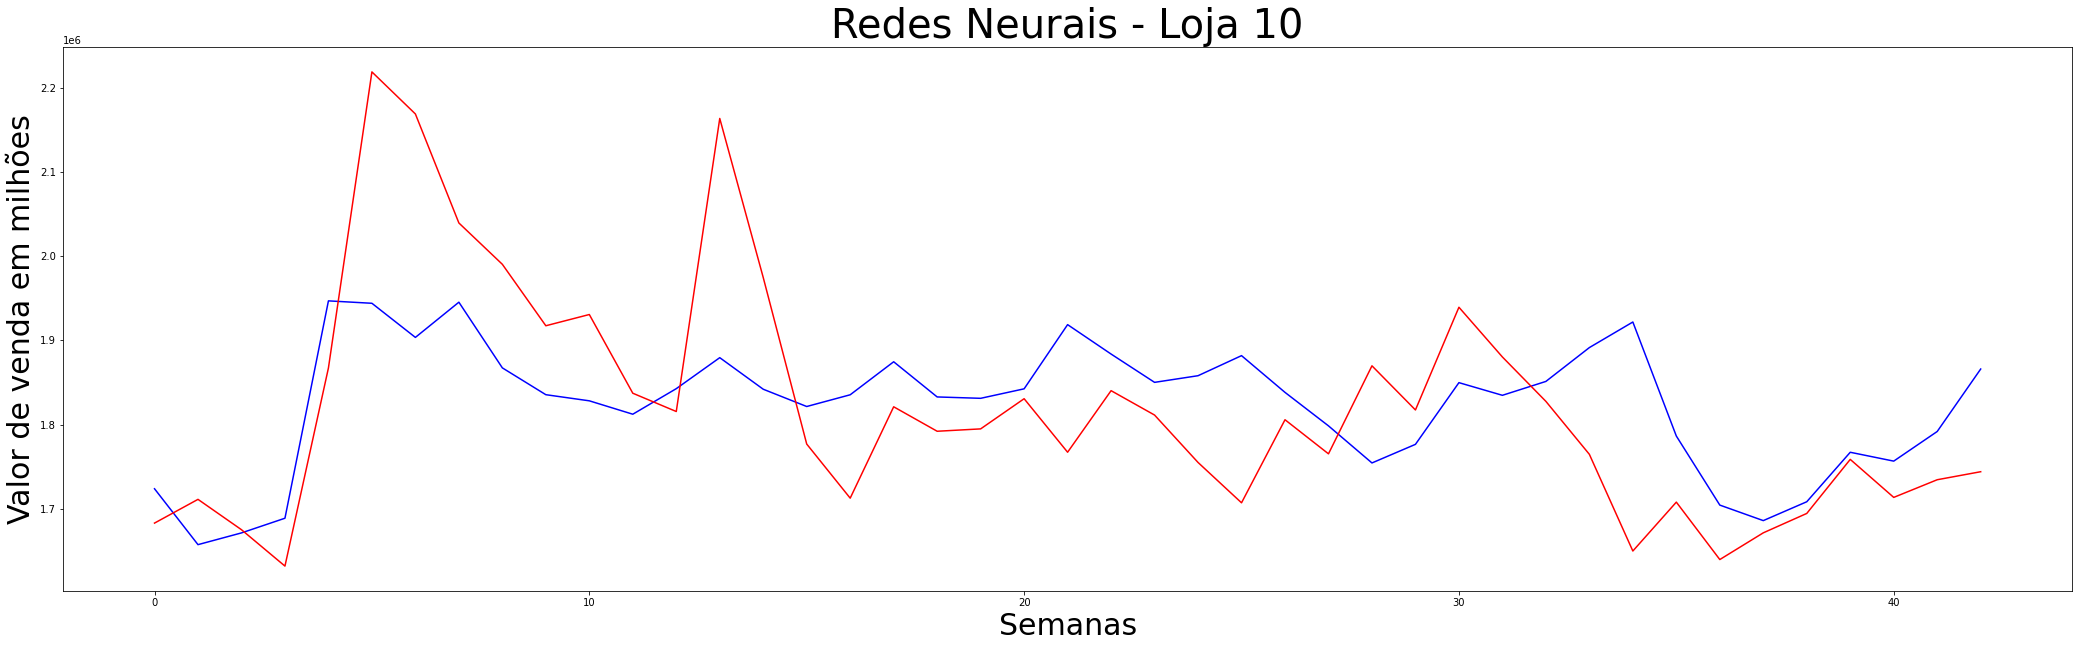

**************************************************
2/2 [==============================] - 0s 13ms/step
Resultados Loja 11:
67431.125 87975.14


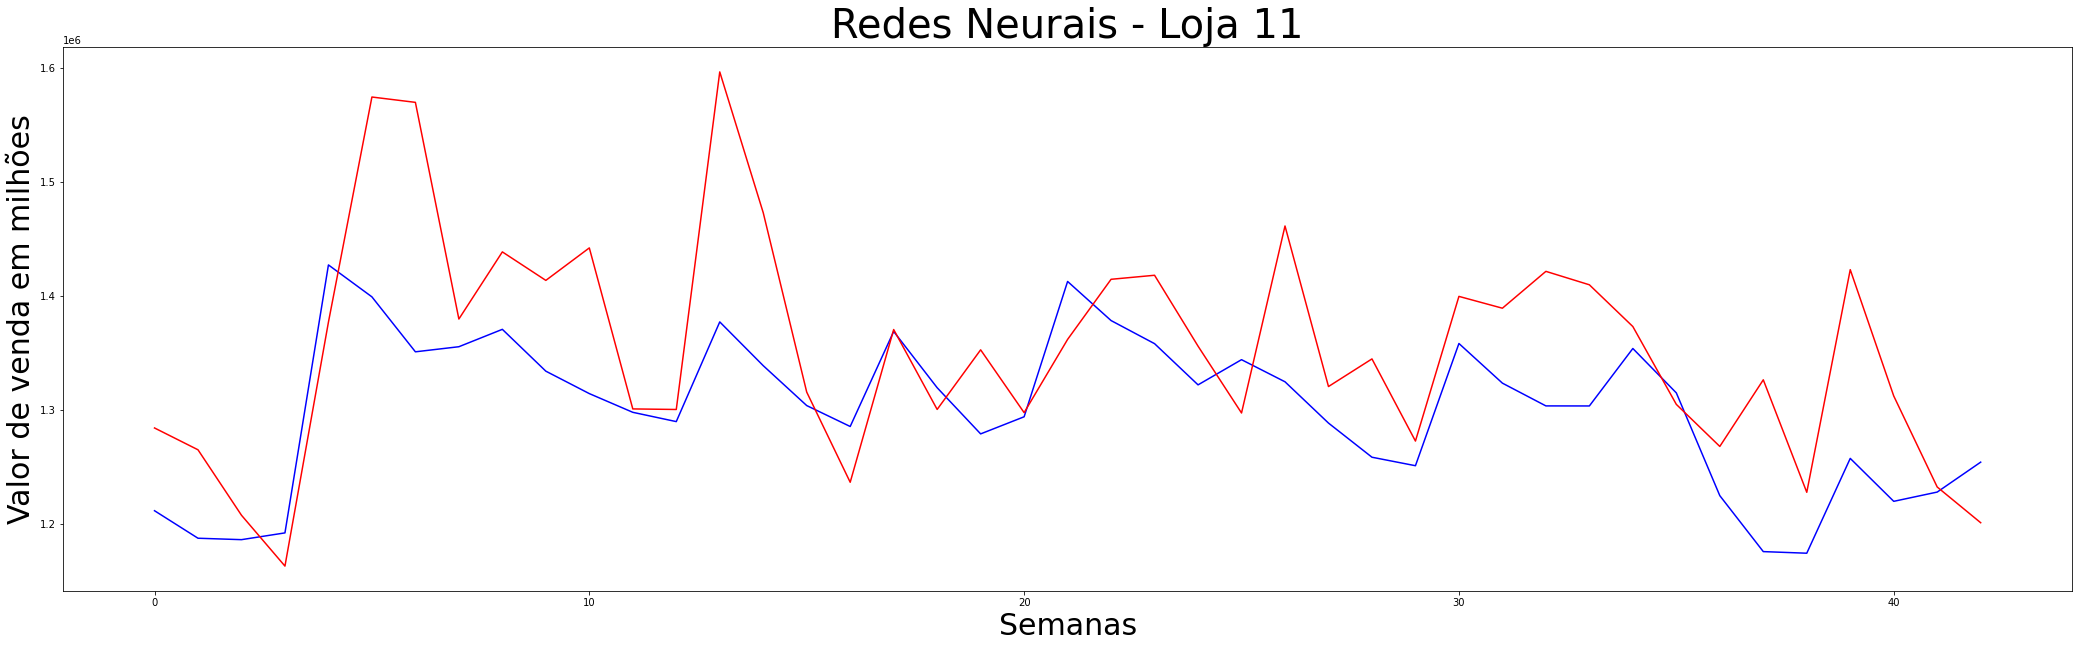

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 12:
108497.98 117499.555


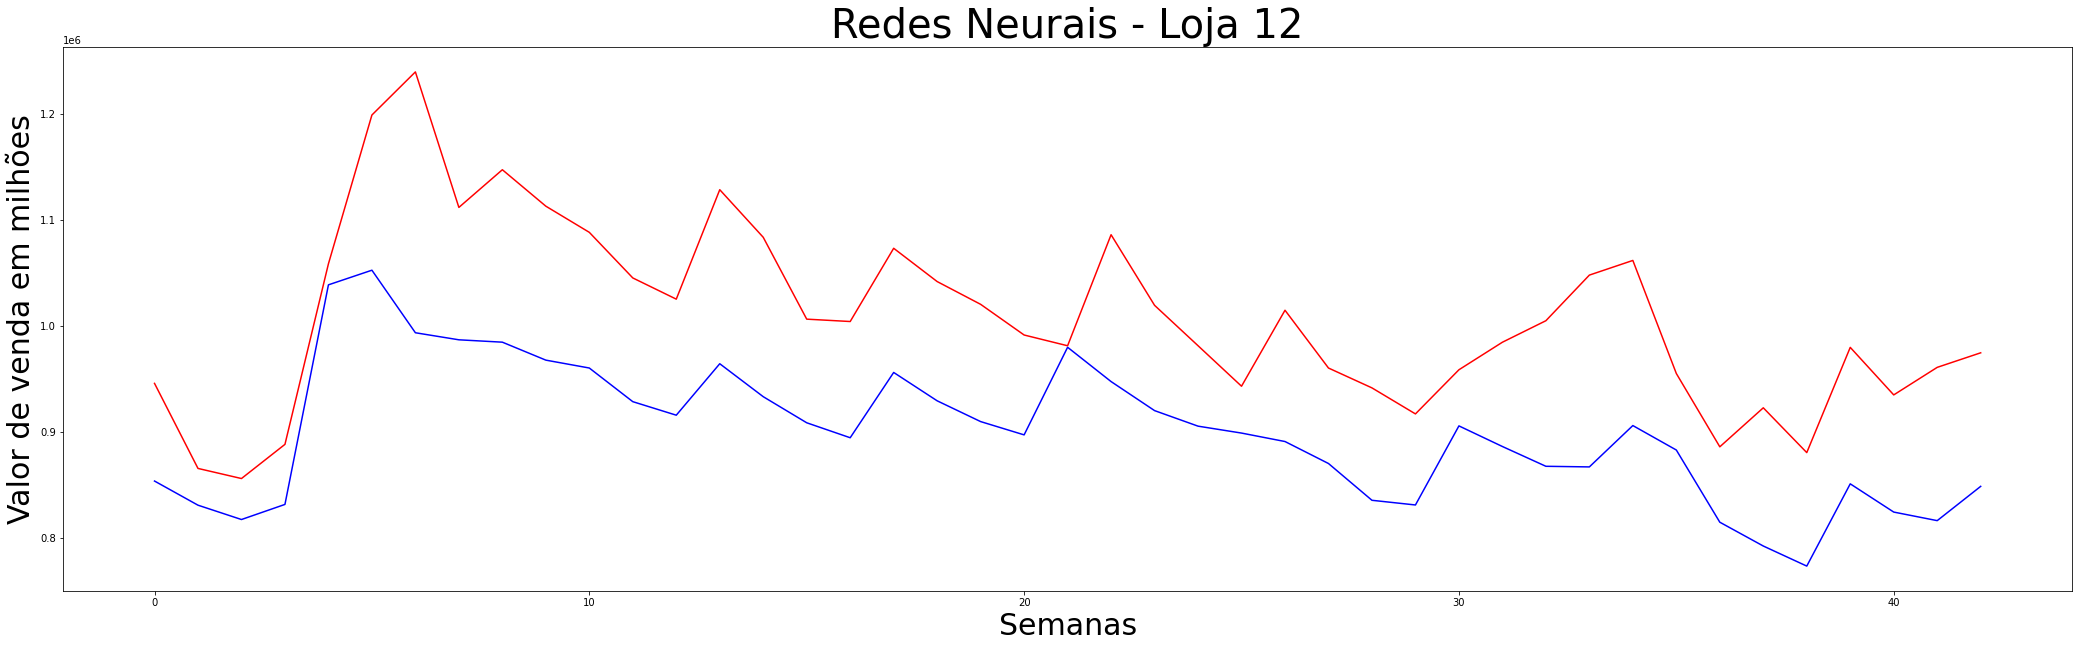

**************************************************
2/2 [==============================] - 0s 5ms/step
Resultados Loja 13:
144654.11 165425.58


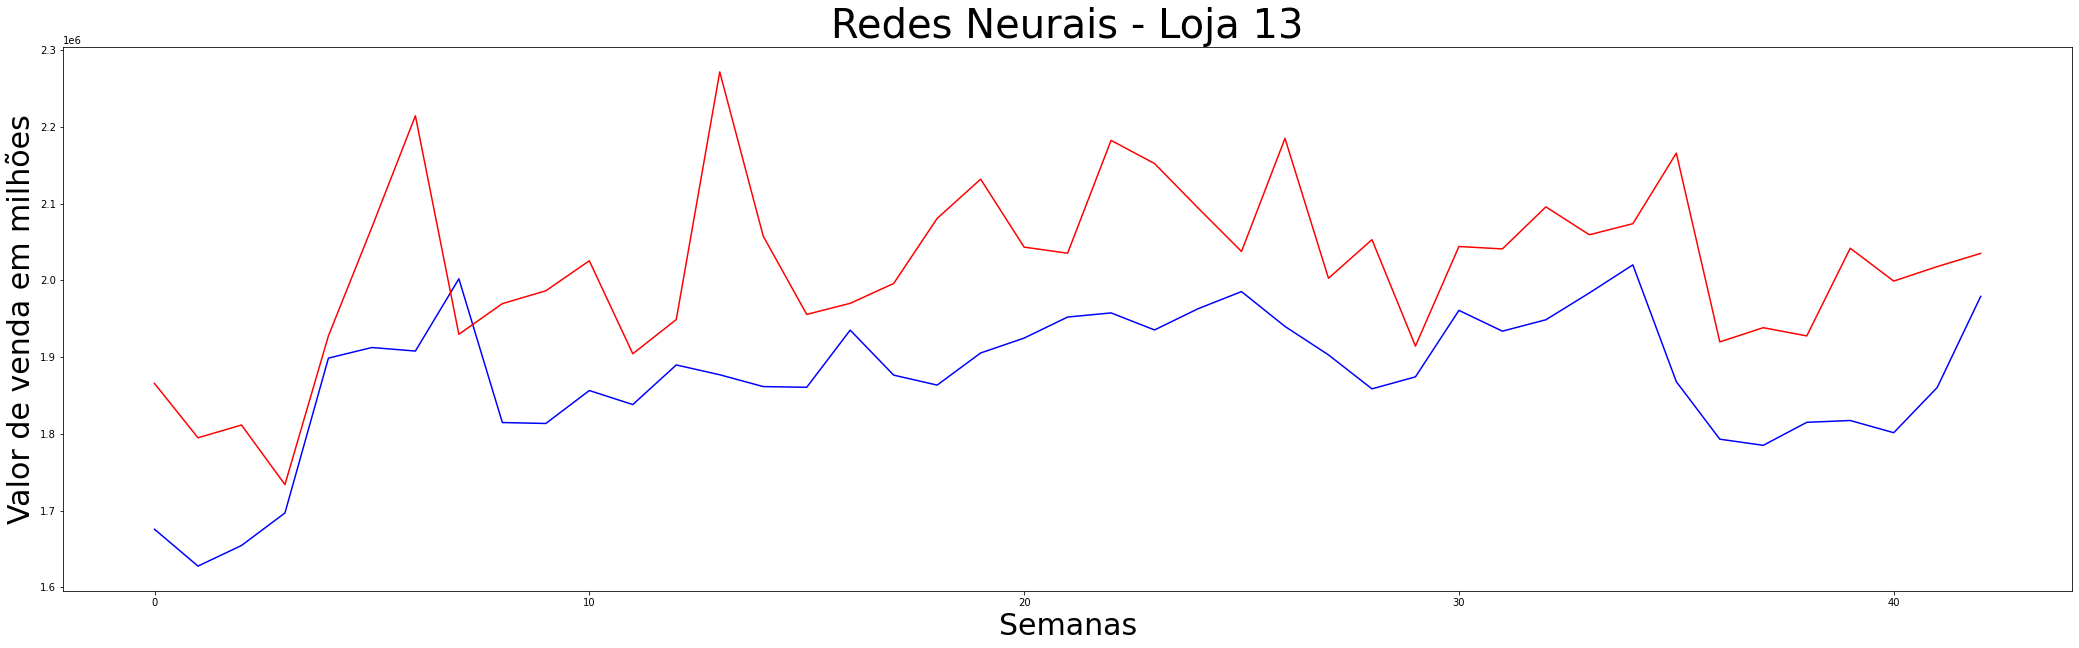

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 14:
261300.81 314058.16


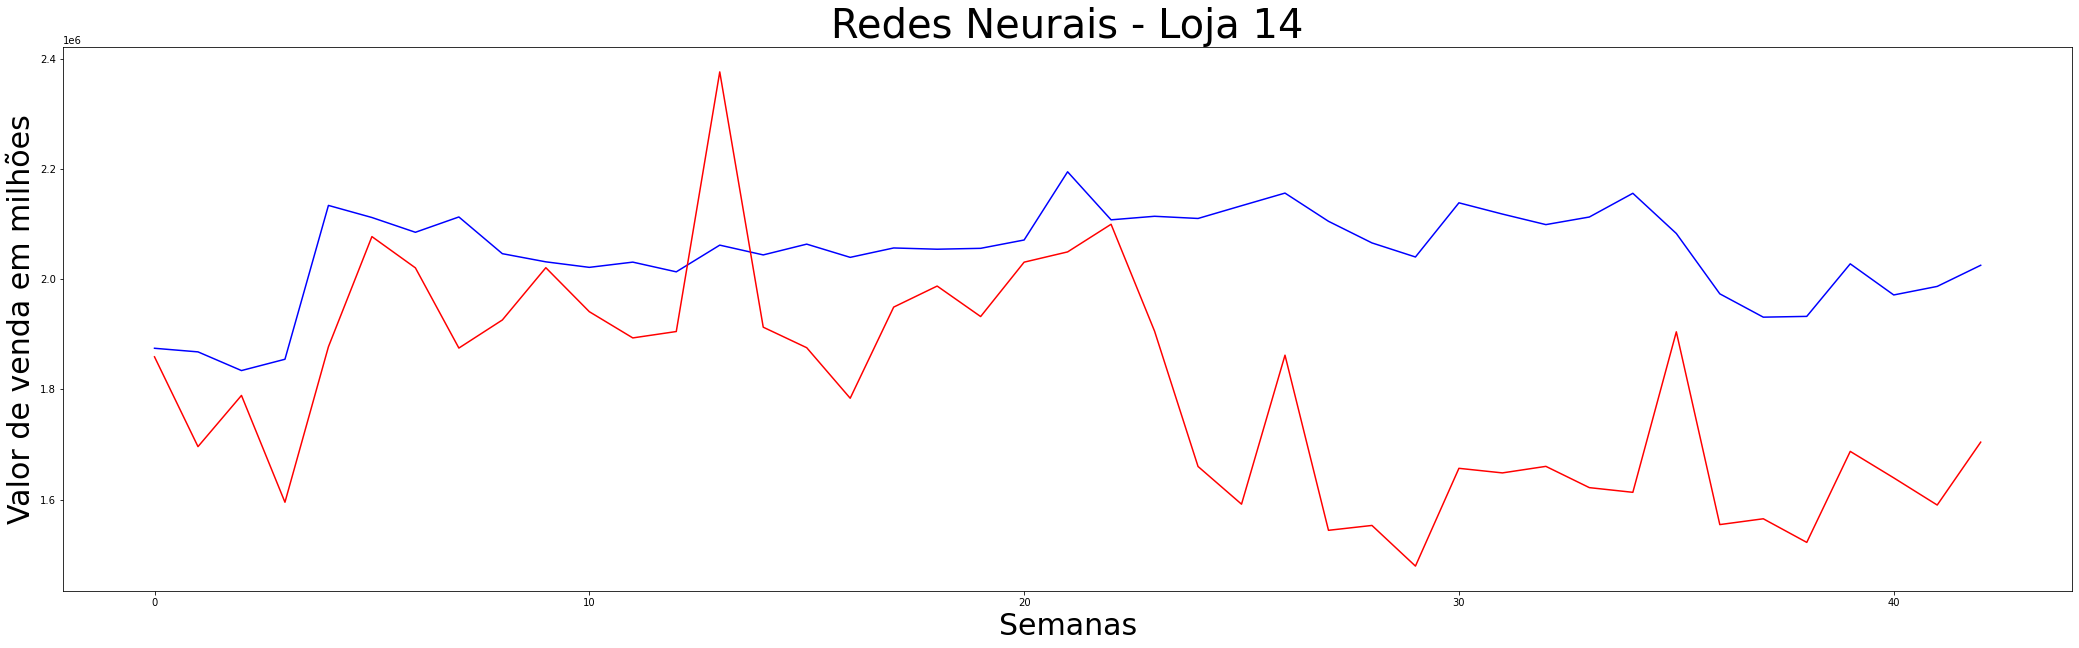

**************************************************
2/2 [==============================] - 0s 14ms/step
Resultados Loja 15:
52623.734 59366.355


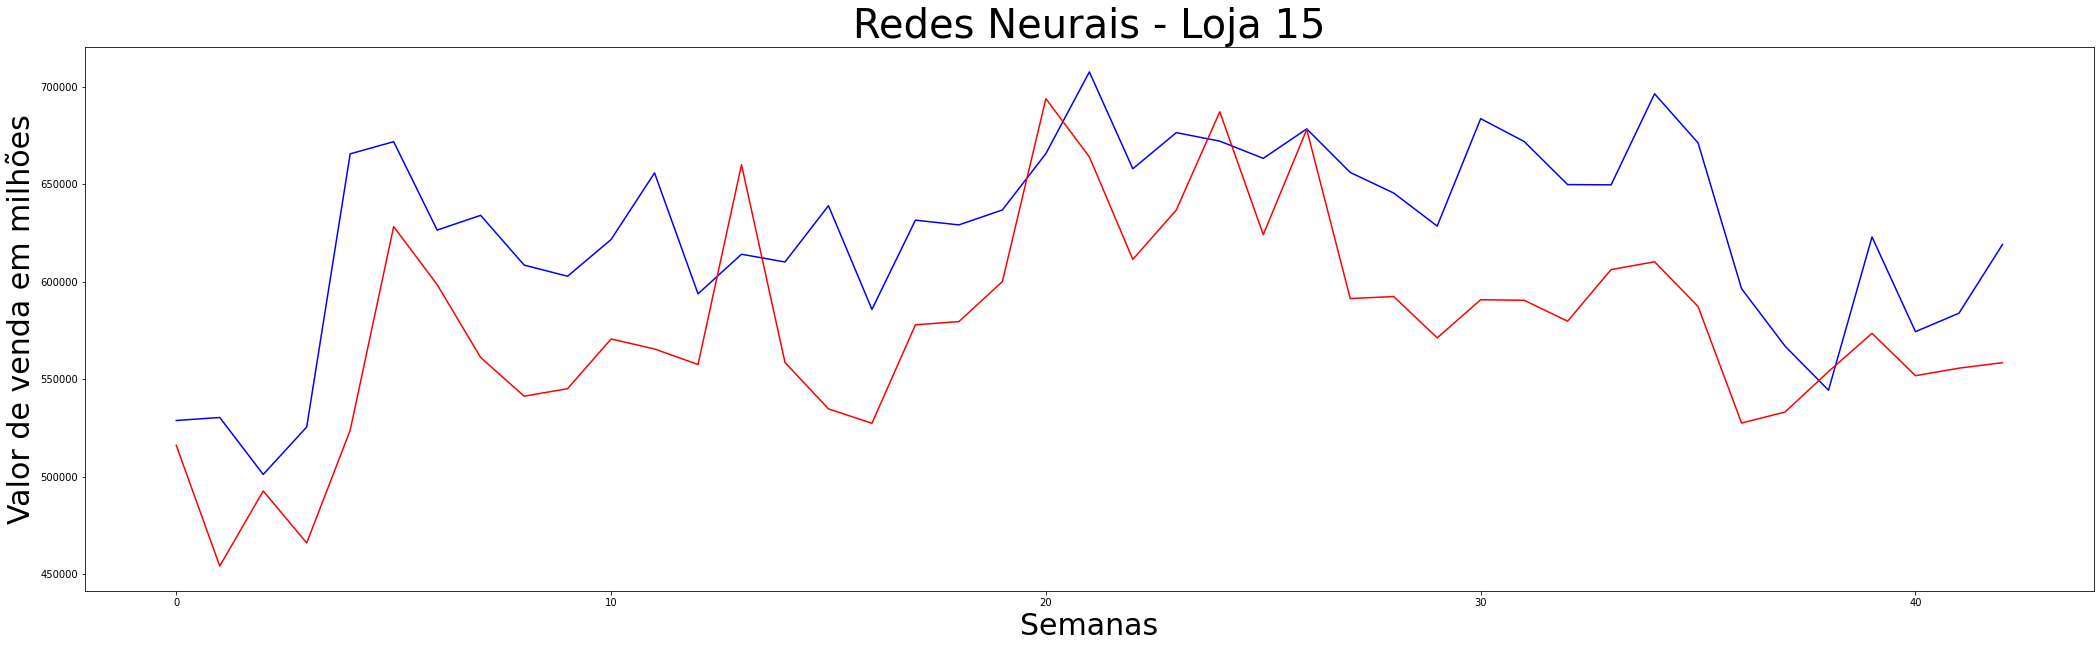

**************************************************
2/2 [==============================] - 0s 14ms/step
Resultados Loja 16:
30572.123 41429.51


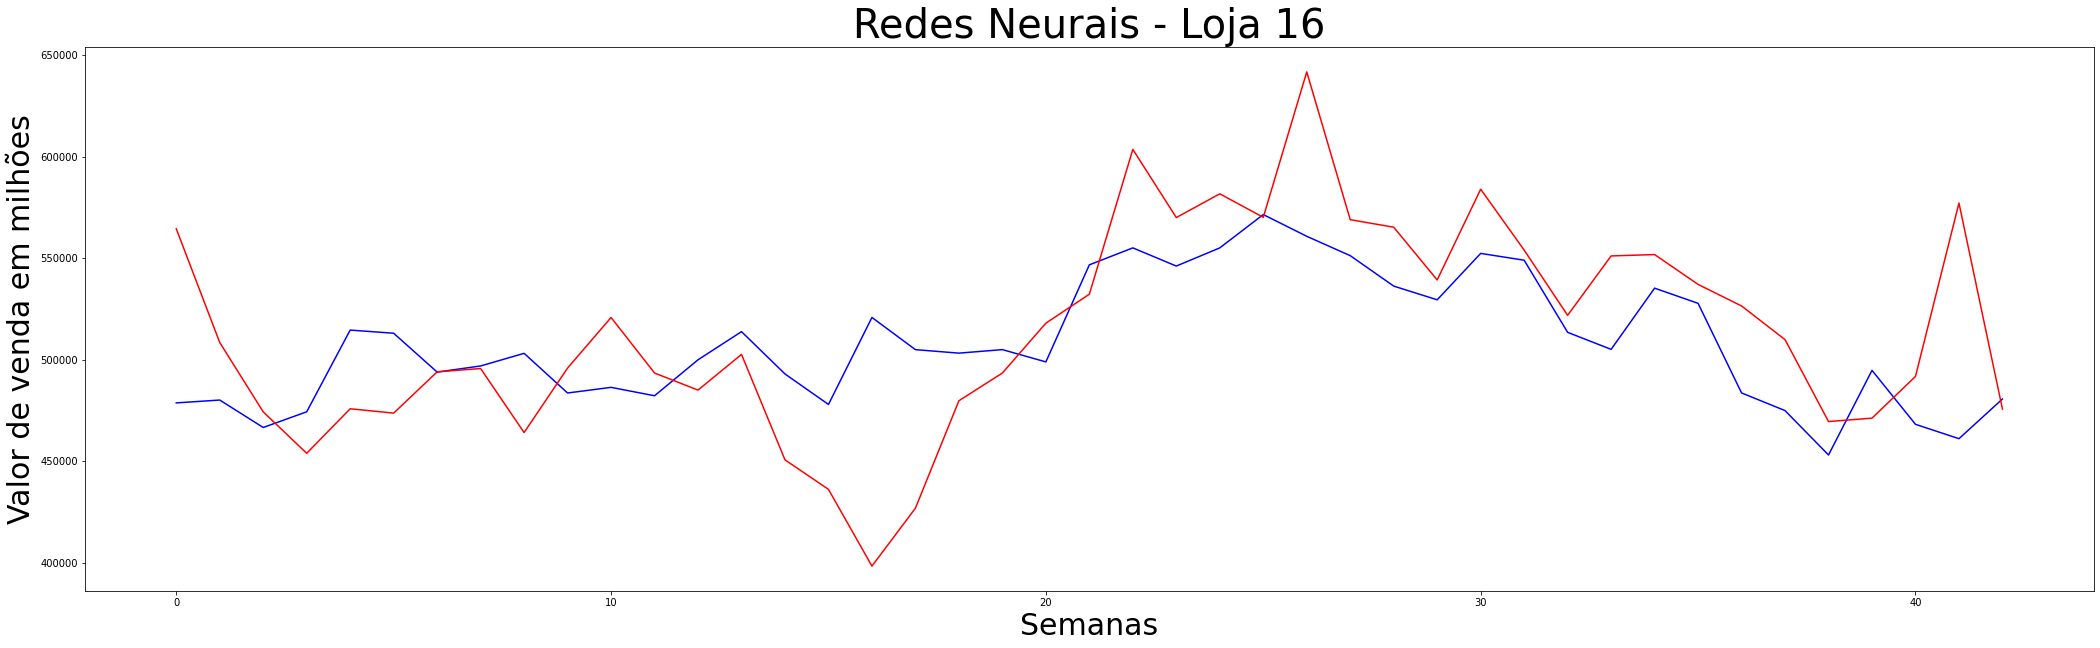

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 17:
109717.78 148317.83


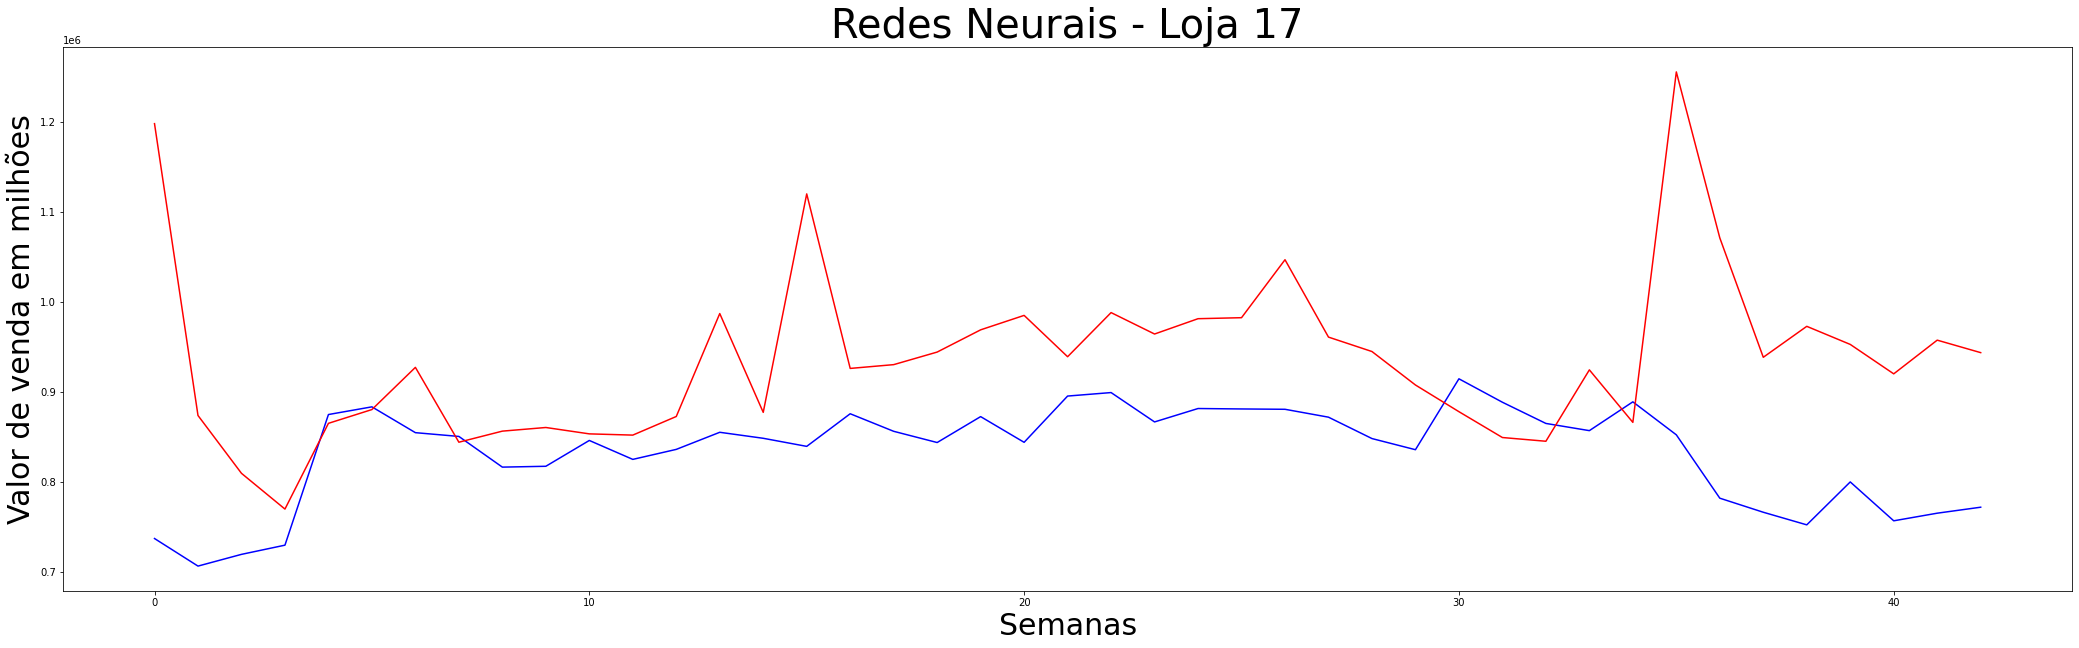

**************************************************
2/2 [==============================] - 0s 5ms/step
Resultados Loja 18:
44634.94 56879.656


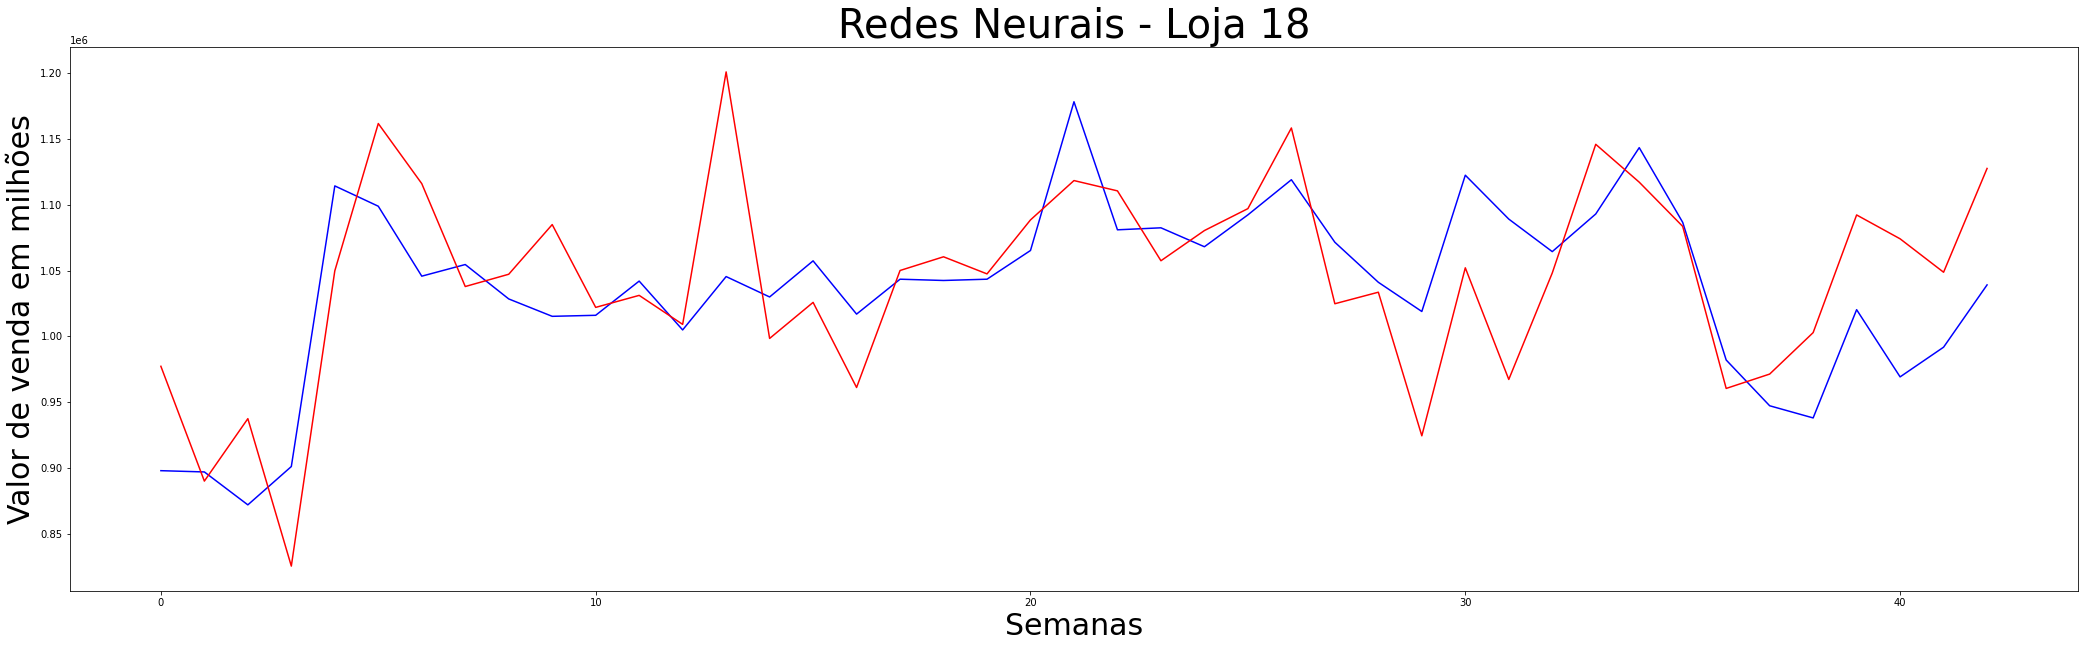

**************************************************
2/2 [==============================] - 0s 10ms/step
Resultados Loja 19:
75130.83 95870.67


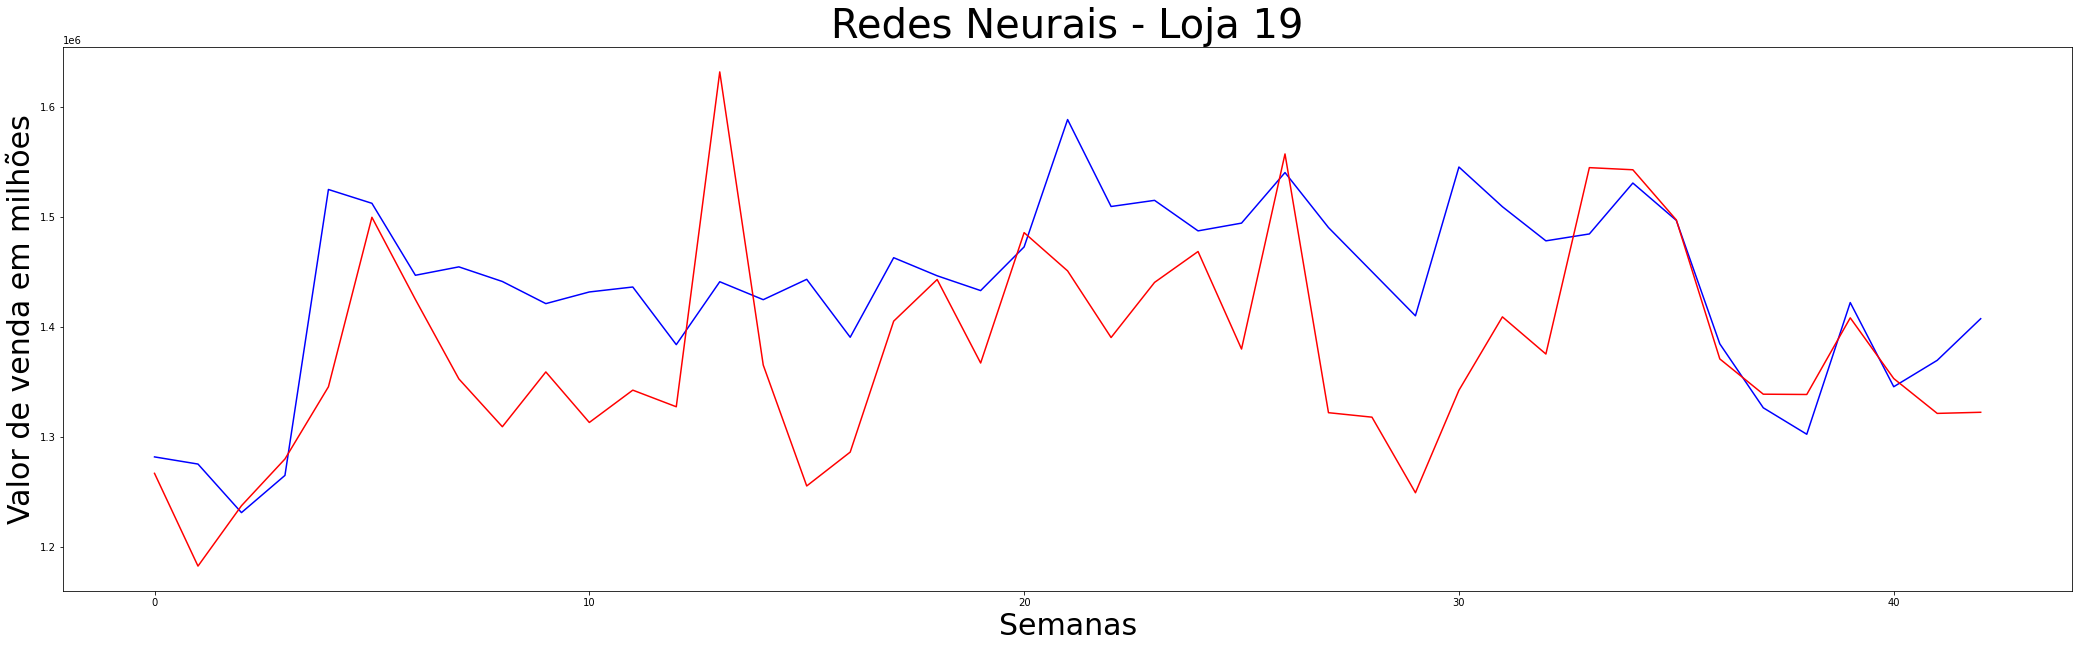

**************************************************
2/2 [==============================] - 0s 5ms/step
Resultados Loja 20:
106953.24 145316.17


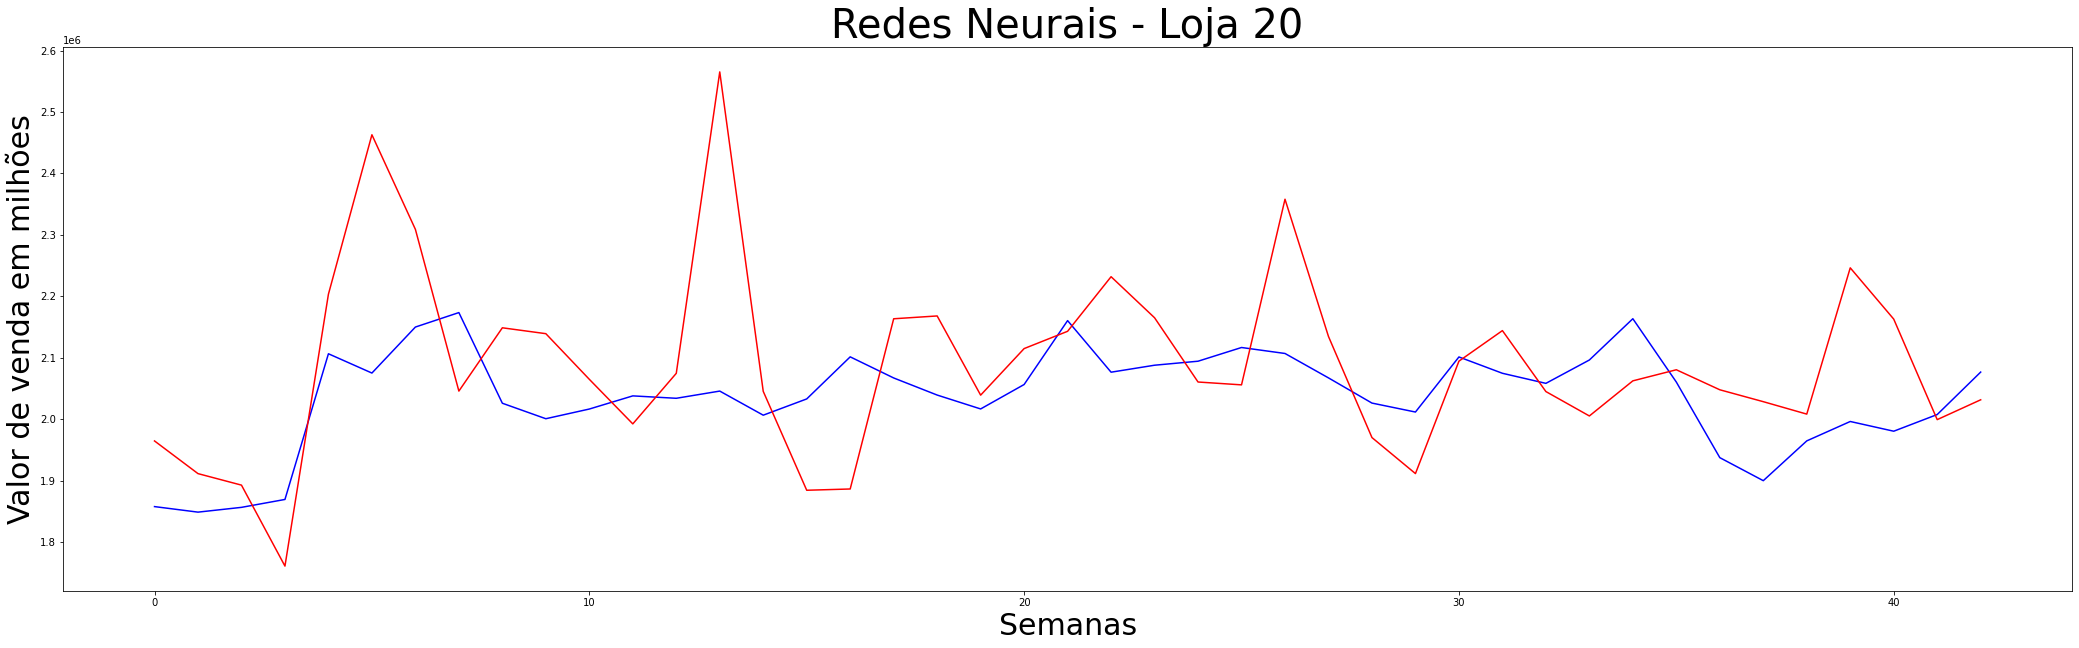

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 21:
40216.836 50404.15


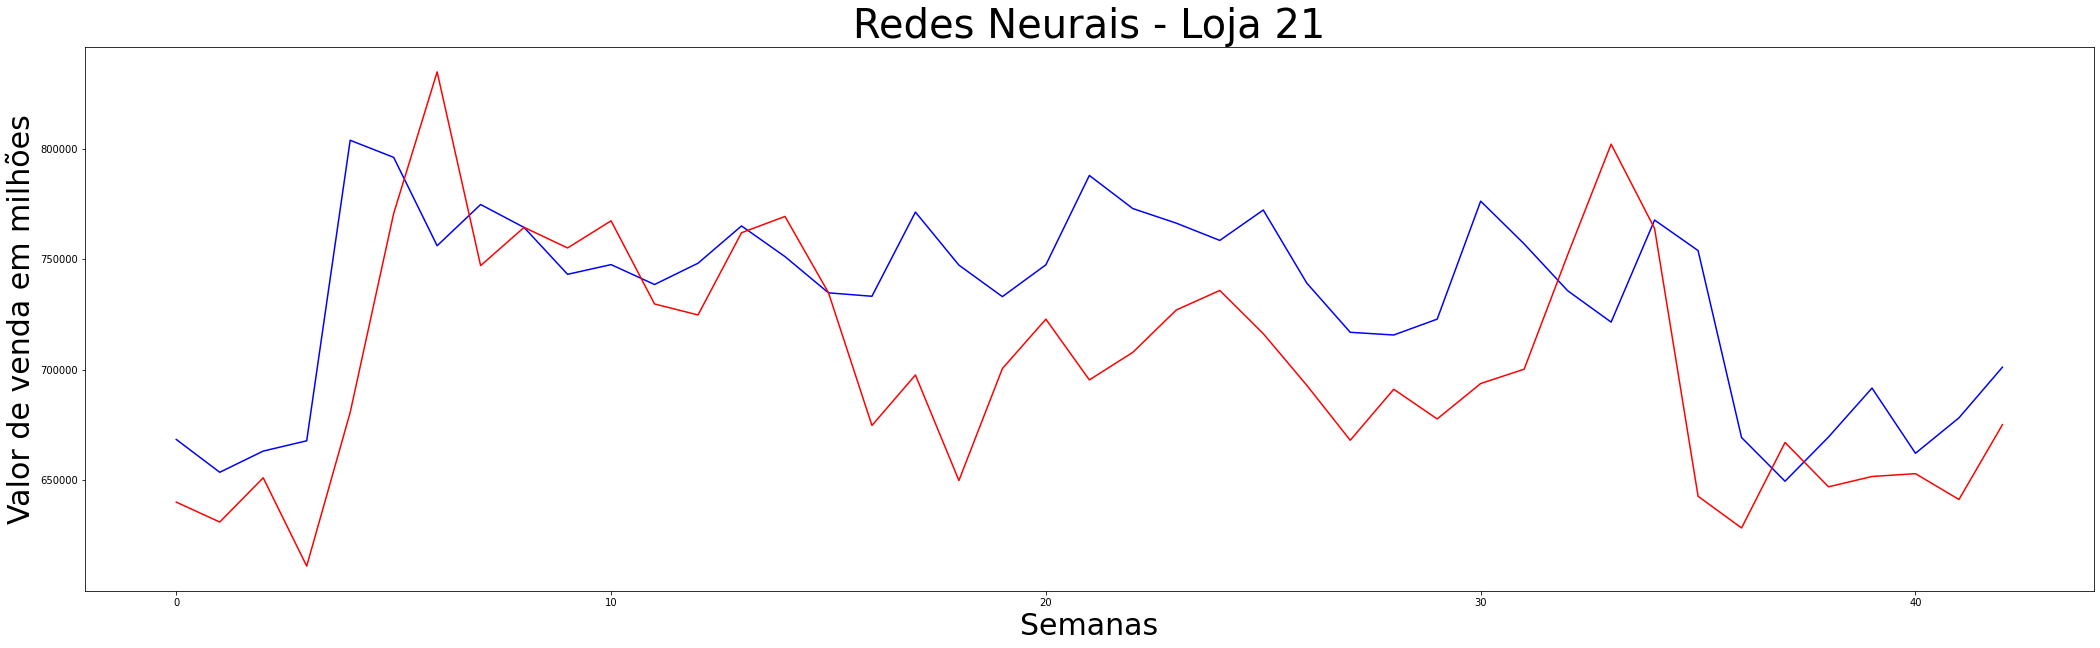

**************************************************
2/2 [==============================] - 0s 16ms/step
Resultados Loja 22:
41636.402 56721.047


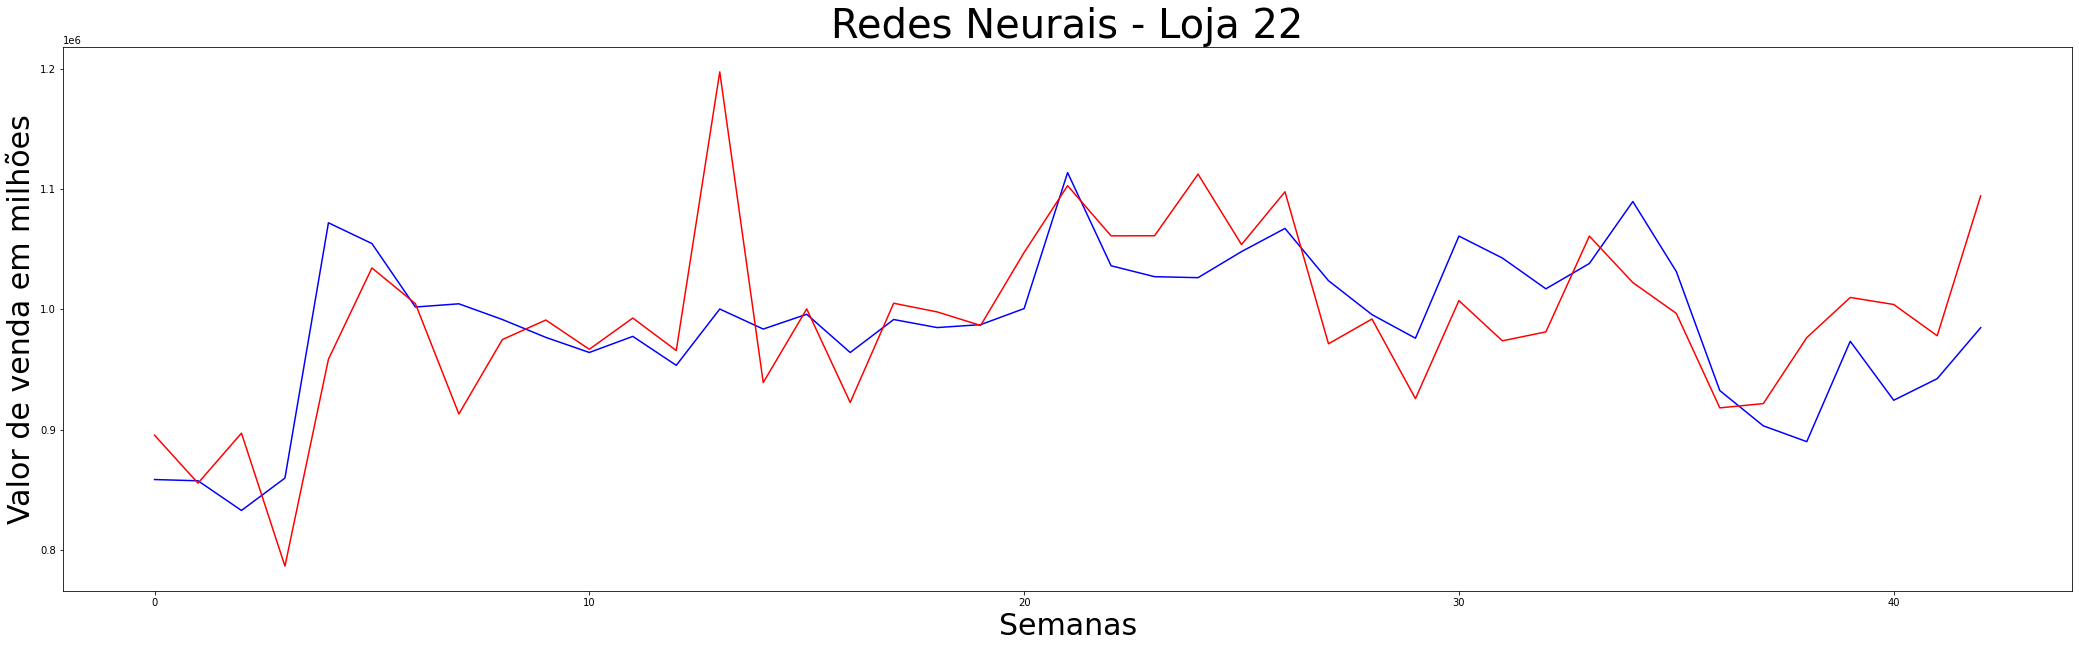

**************************************************
2/2 [==============================] - 0s 5ms/step
Resultados Loja 23:
86273.51 115492.266


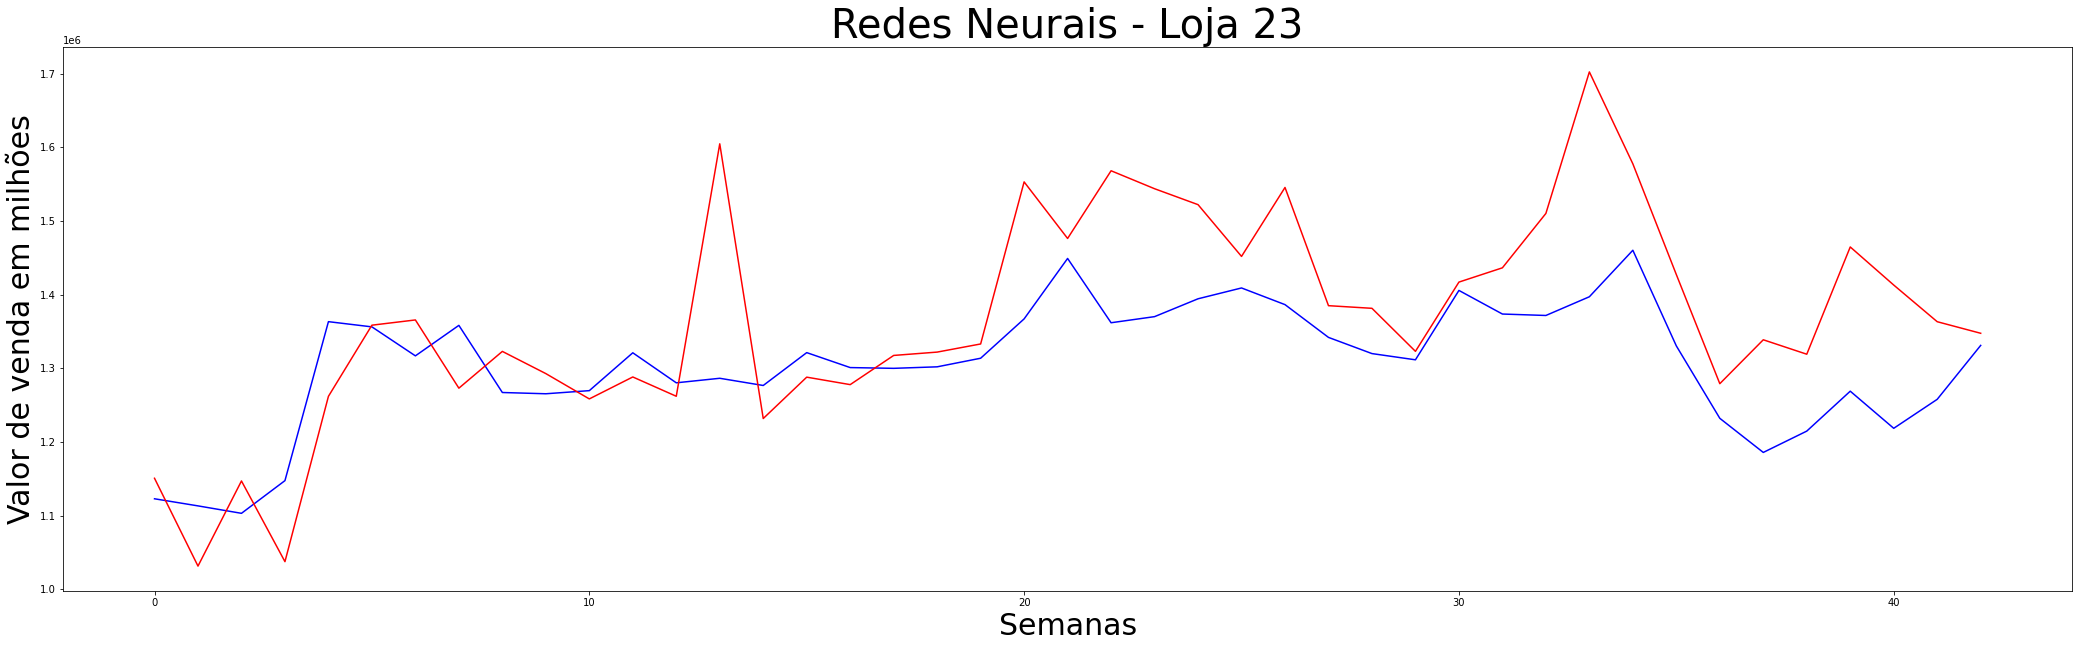

**************************************************
2/2 [==============================] - 0s 5ms/step
Resultados Loja 24:
65820.79 83528.74


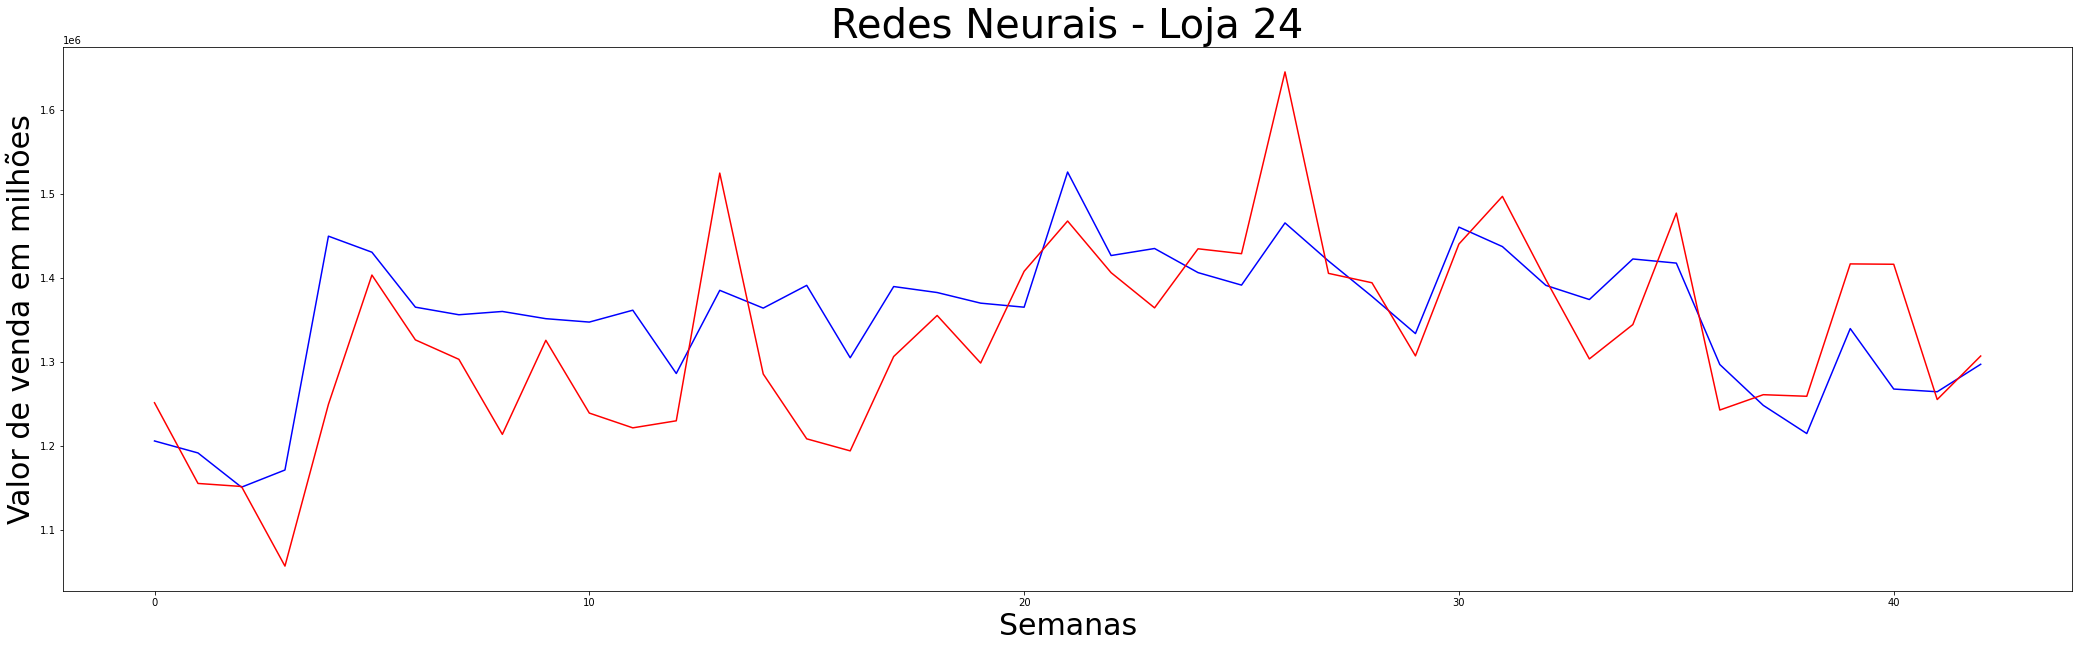

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 25:
36396.32 45546.05


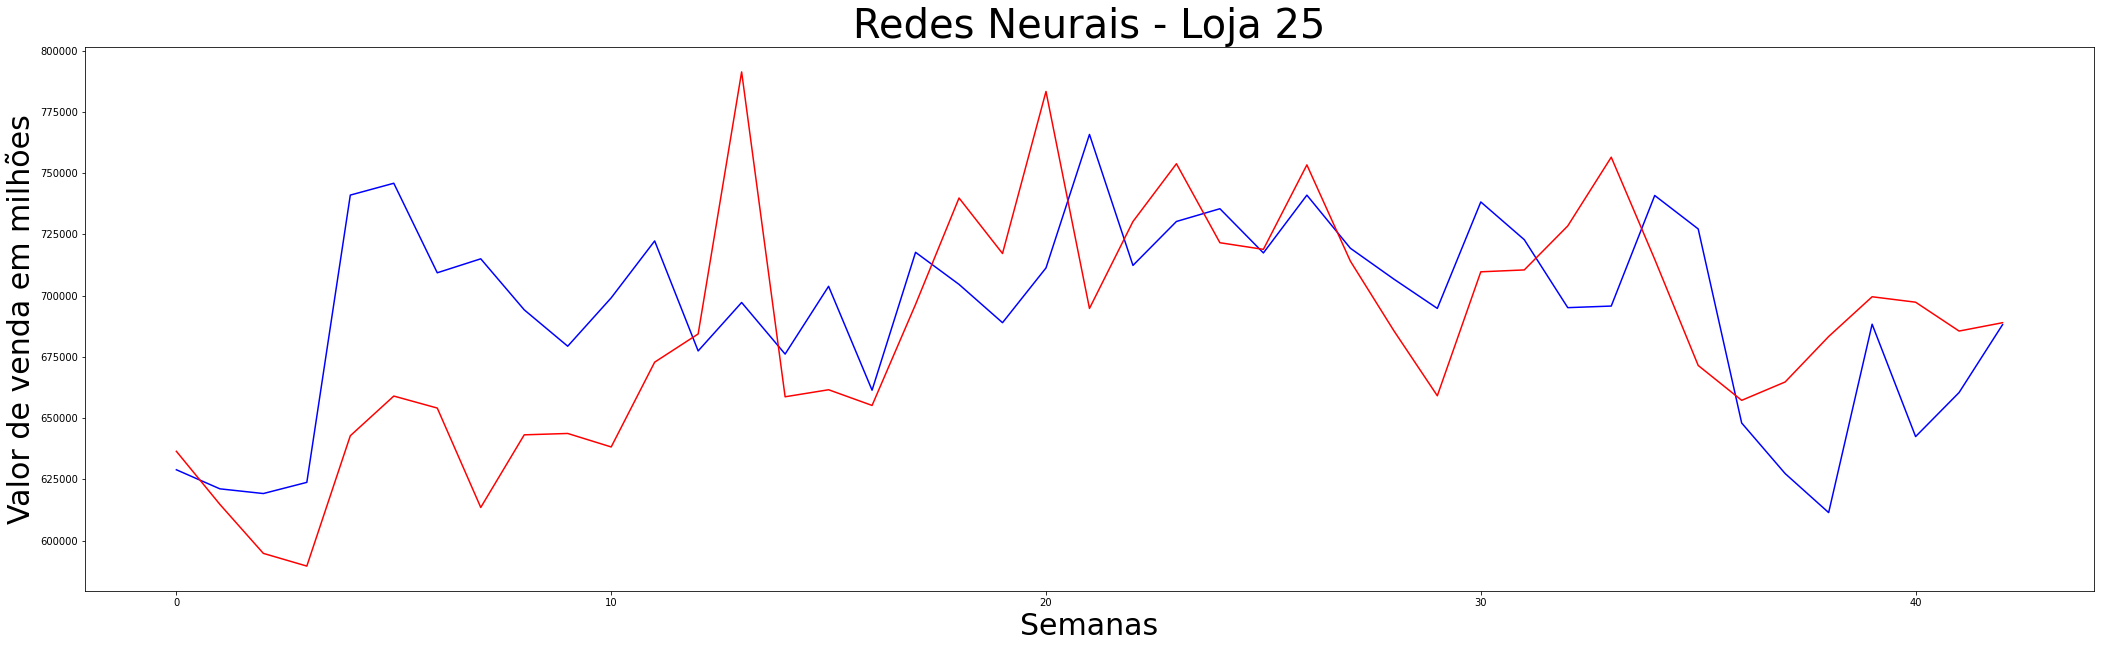

**************************************************
2/2 [==============================] - 0s 12ms/step
Resultados Loja 26:
66907.85 78923.984


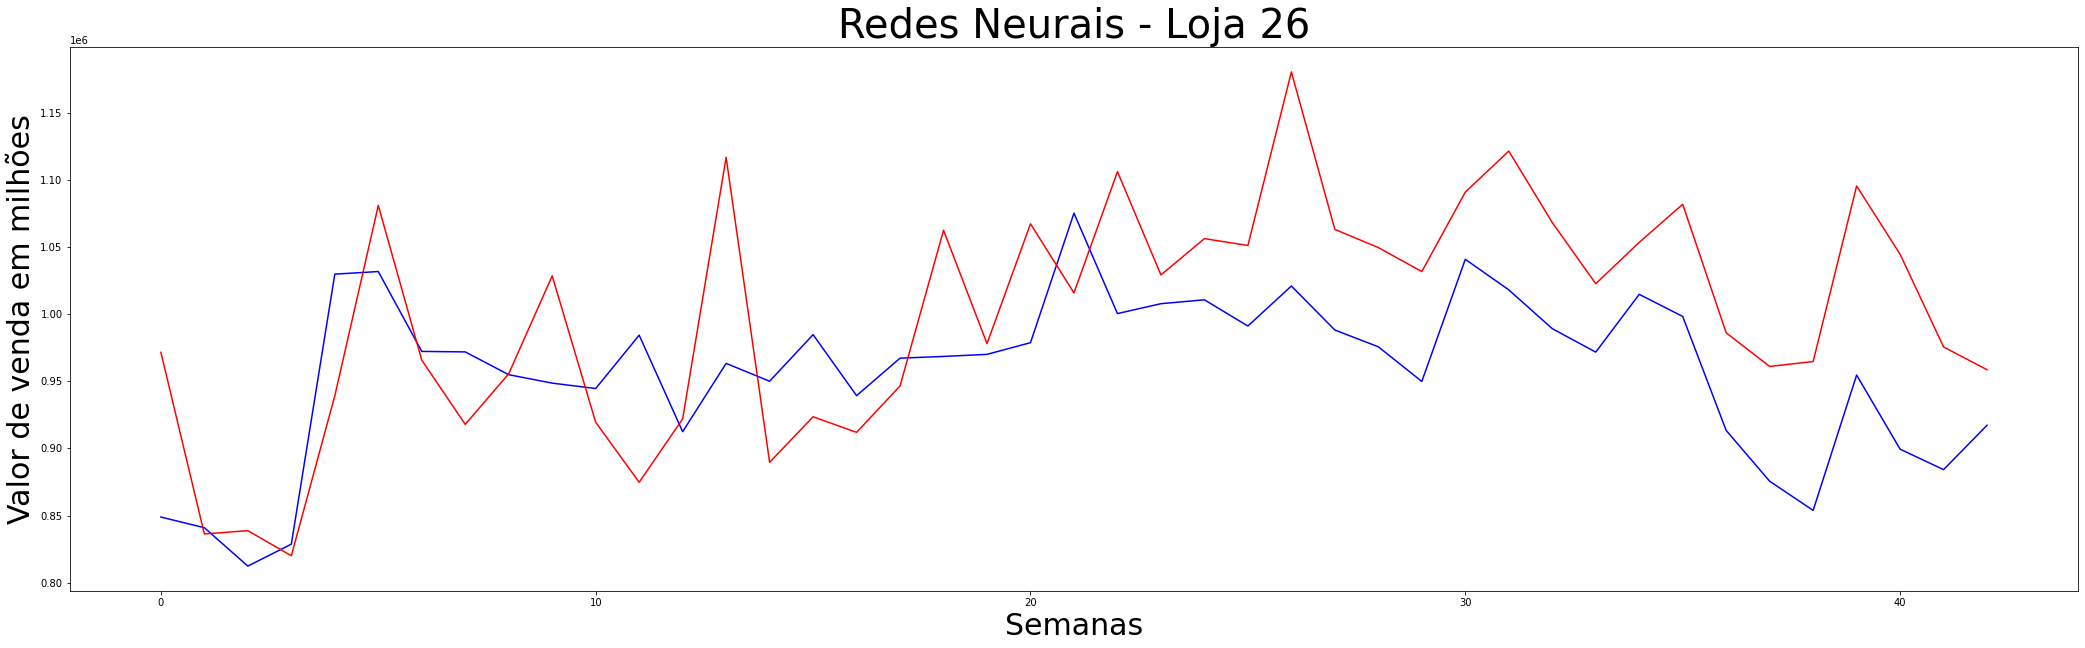

**************************************************
2/2 [==============================] - 0s 7ms/step
Resultados Loja 27:
117789.38 137754.86


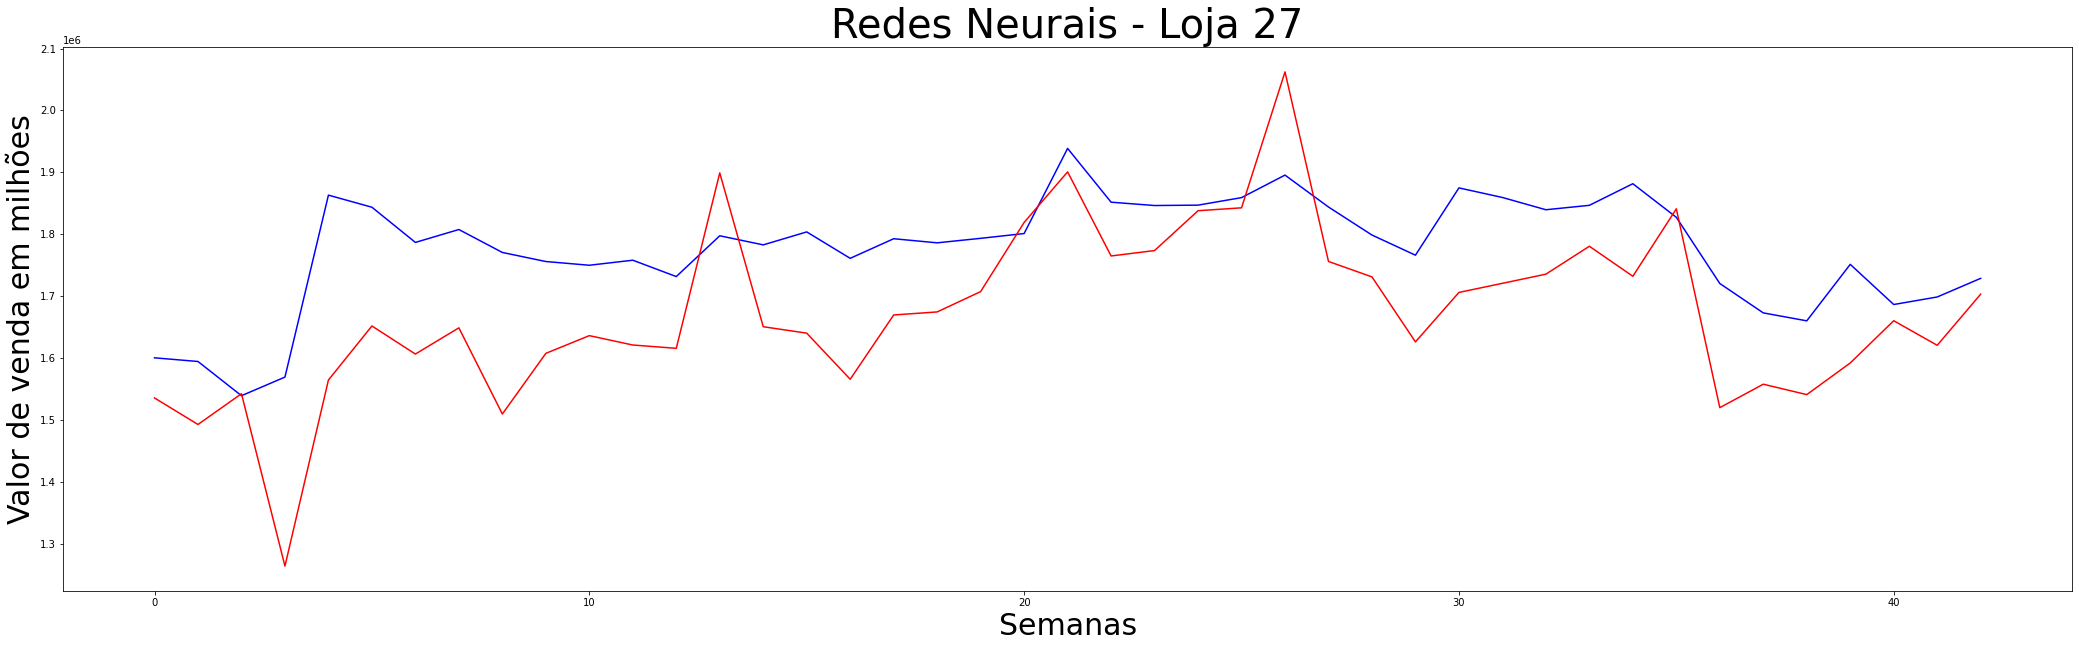

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 28:
82962.76 119460.27


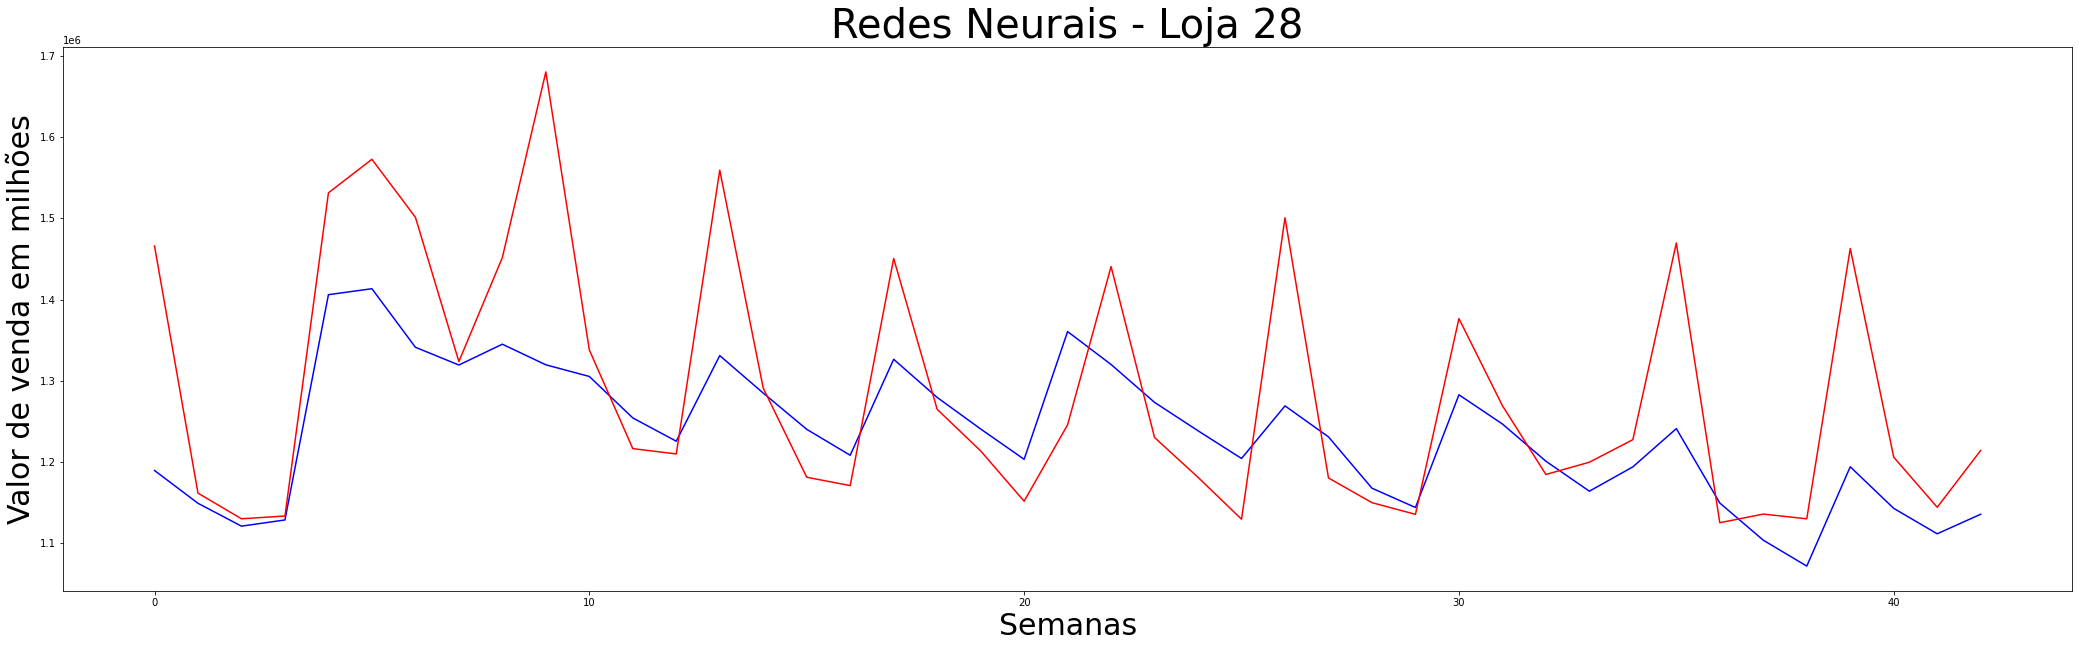

**************************************************
2/2 [==============================] - 0s 7ms/step
Resultados Loja 29:
29981.031 39964.977


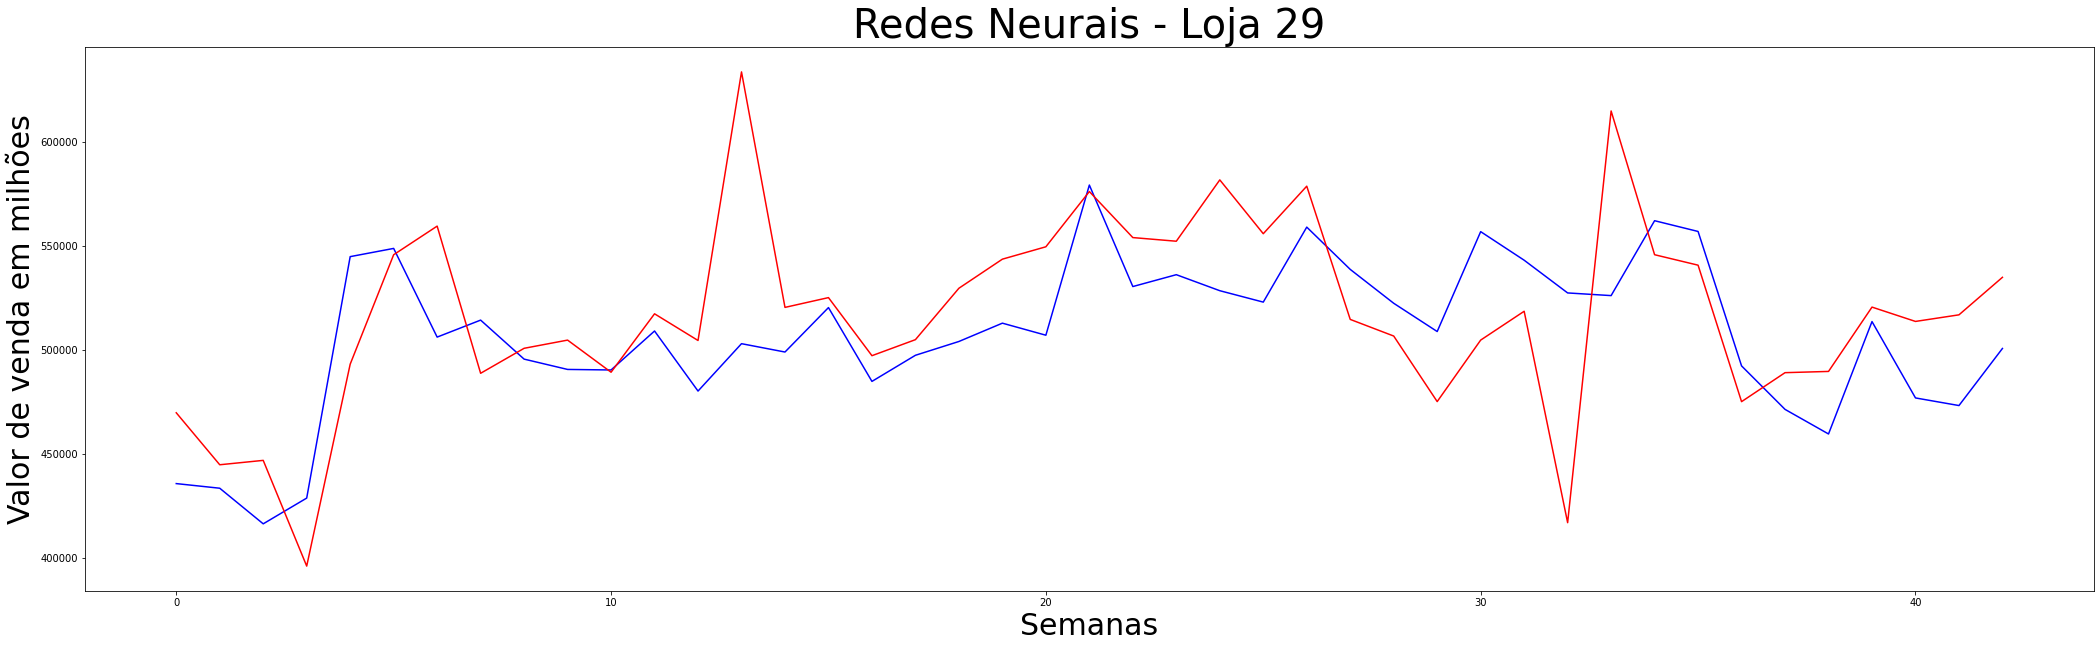

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 30:
18852.564 22957.986


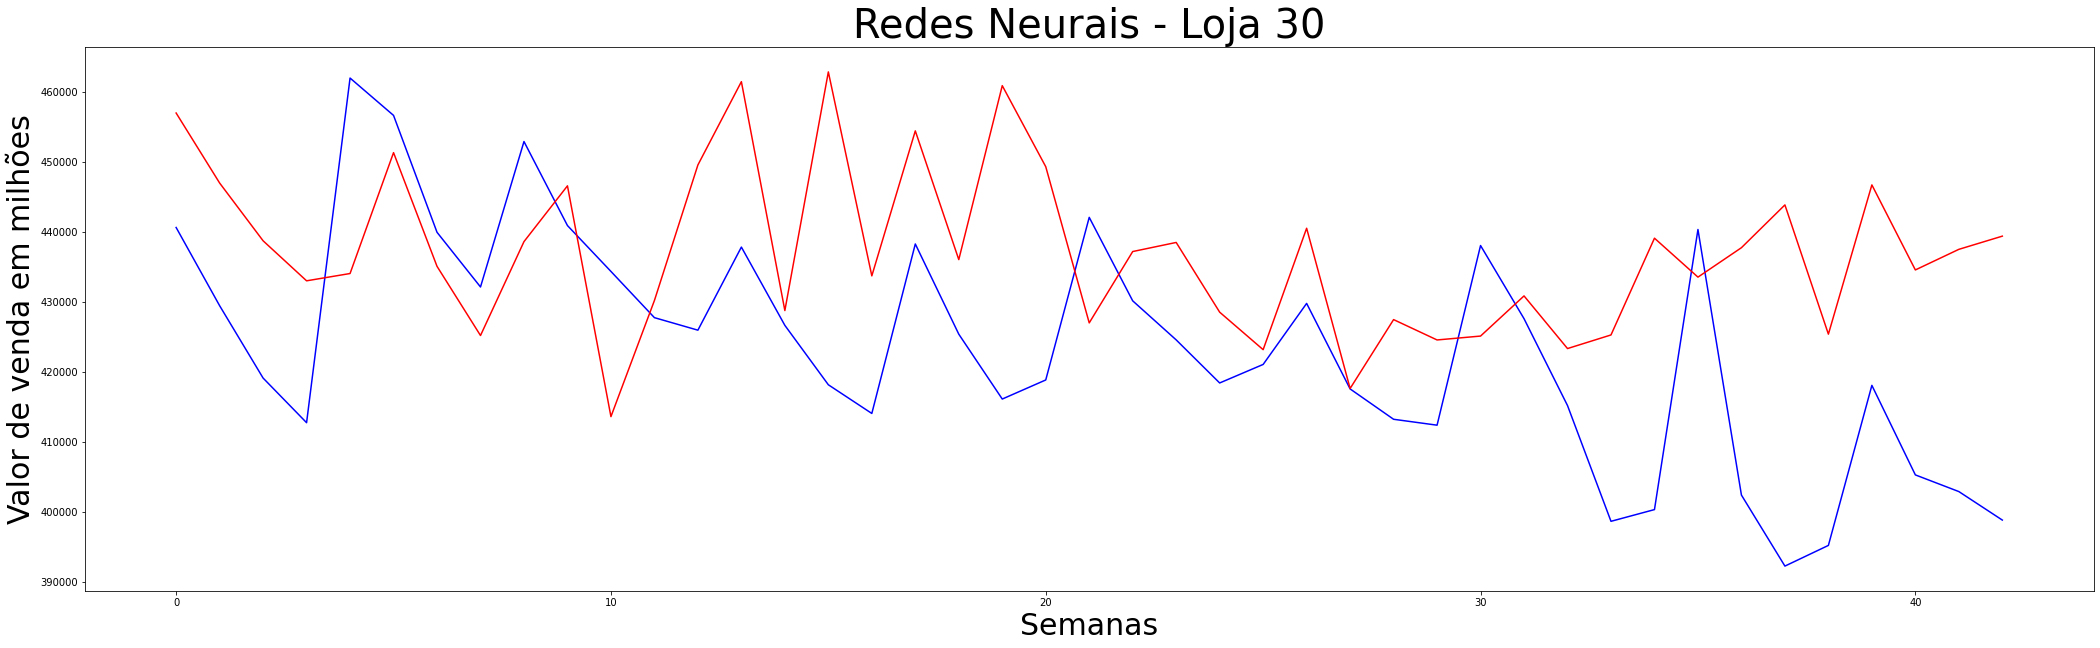

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 31:
69688.664 87112.266


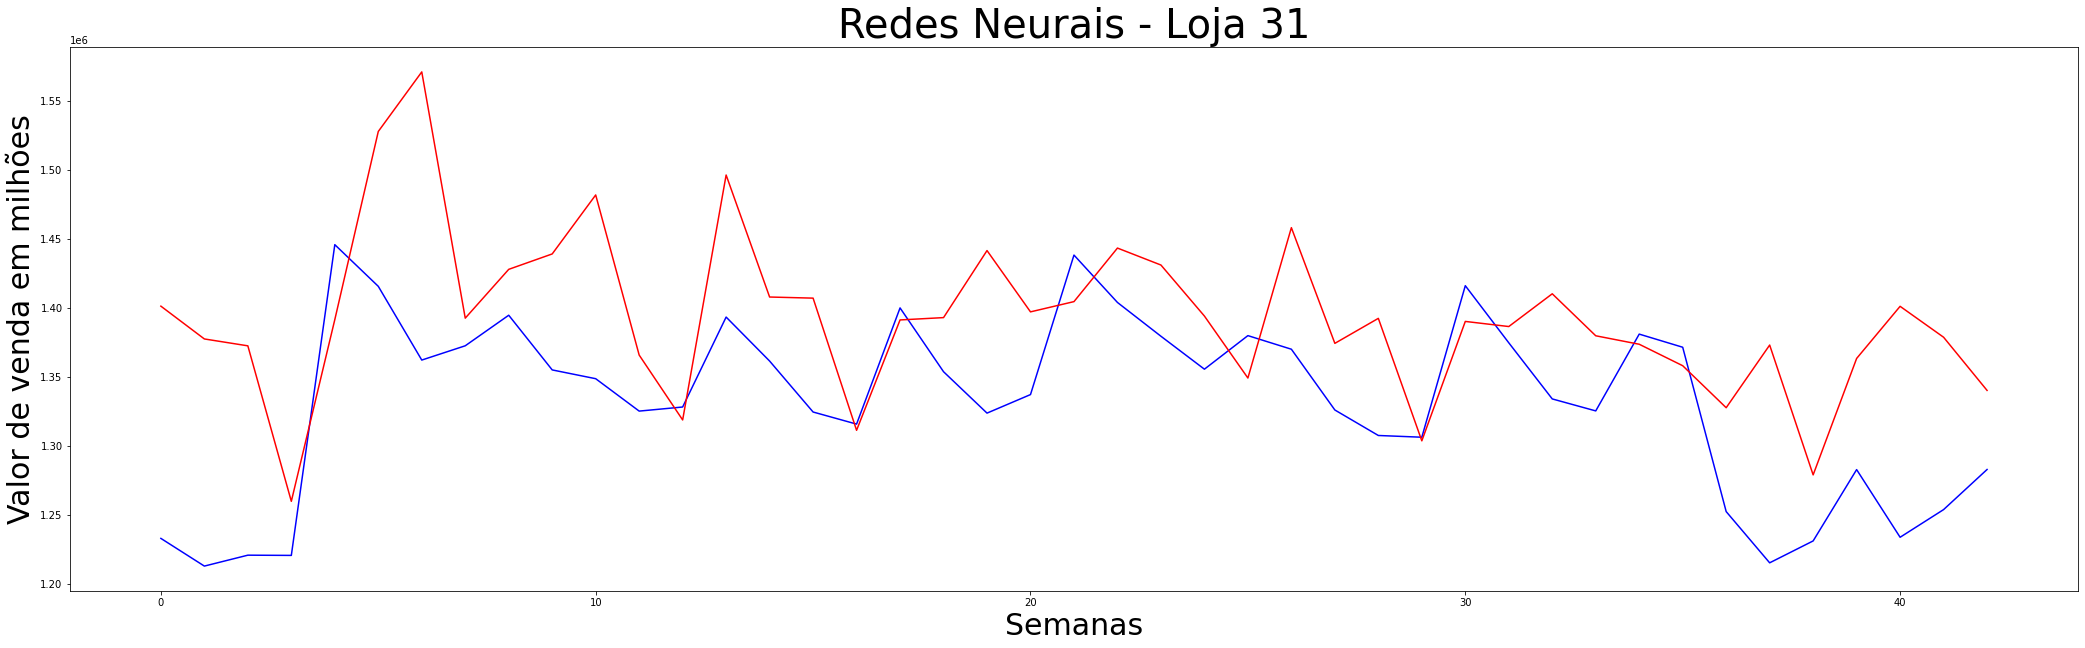

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 32:
69103.49 85288.32


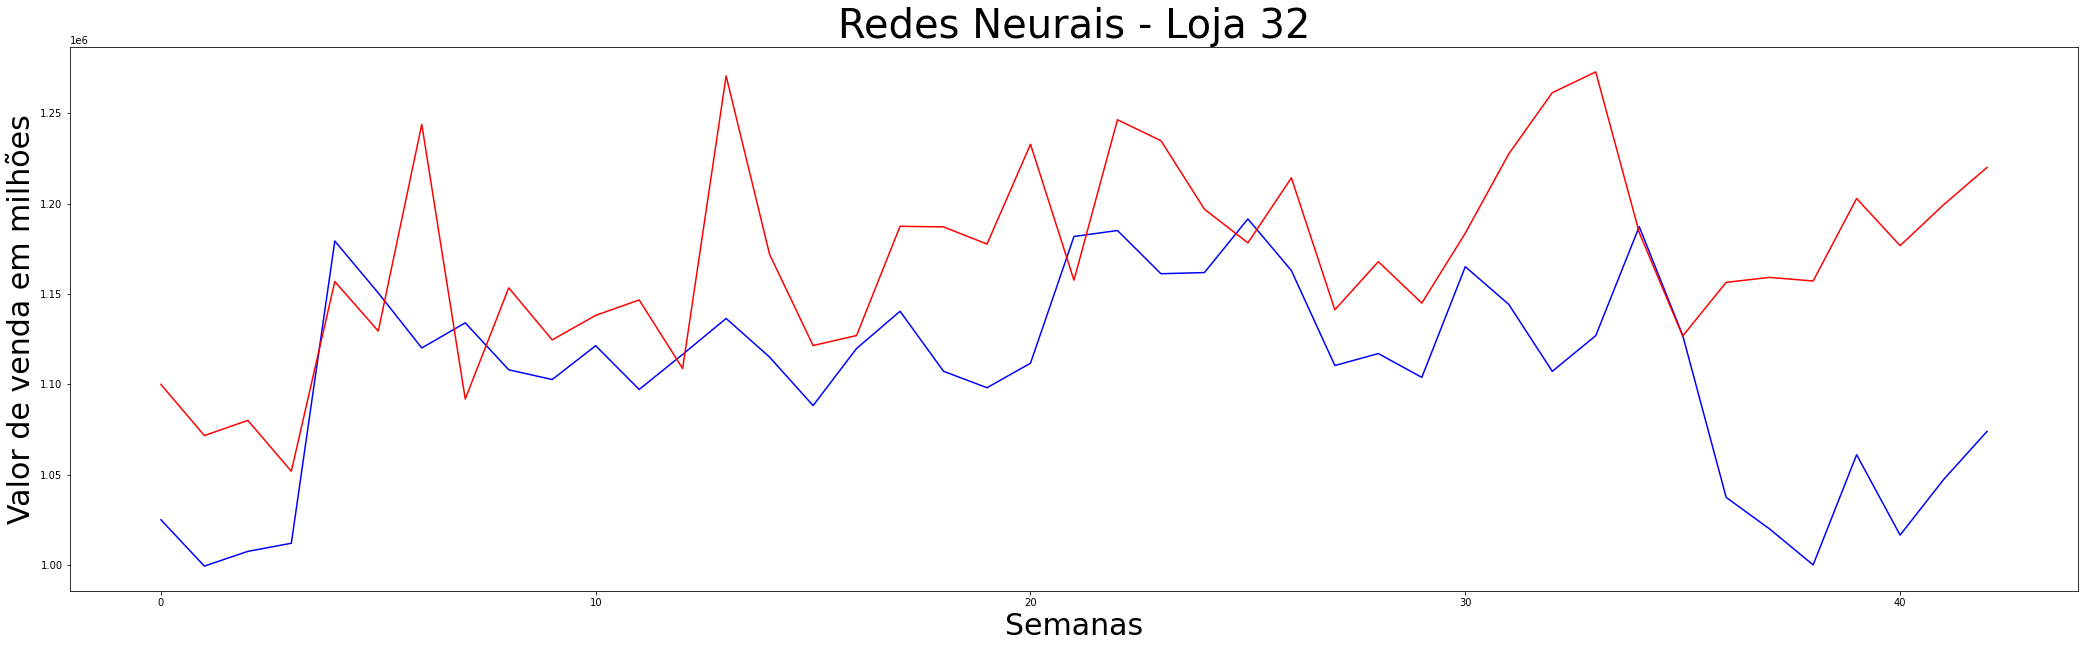

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 33:
37256.5 40868.555


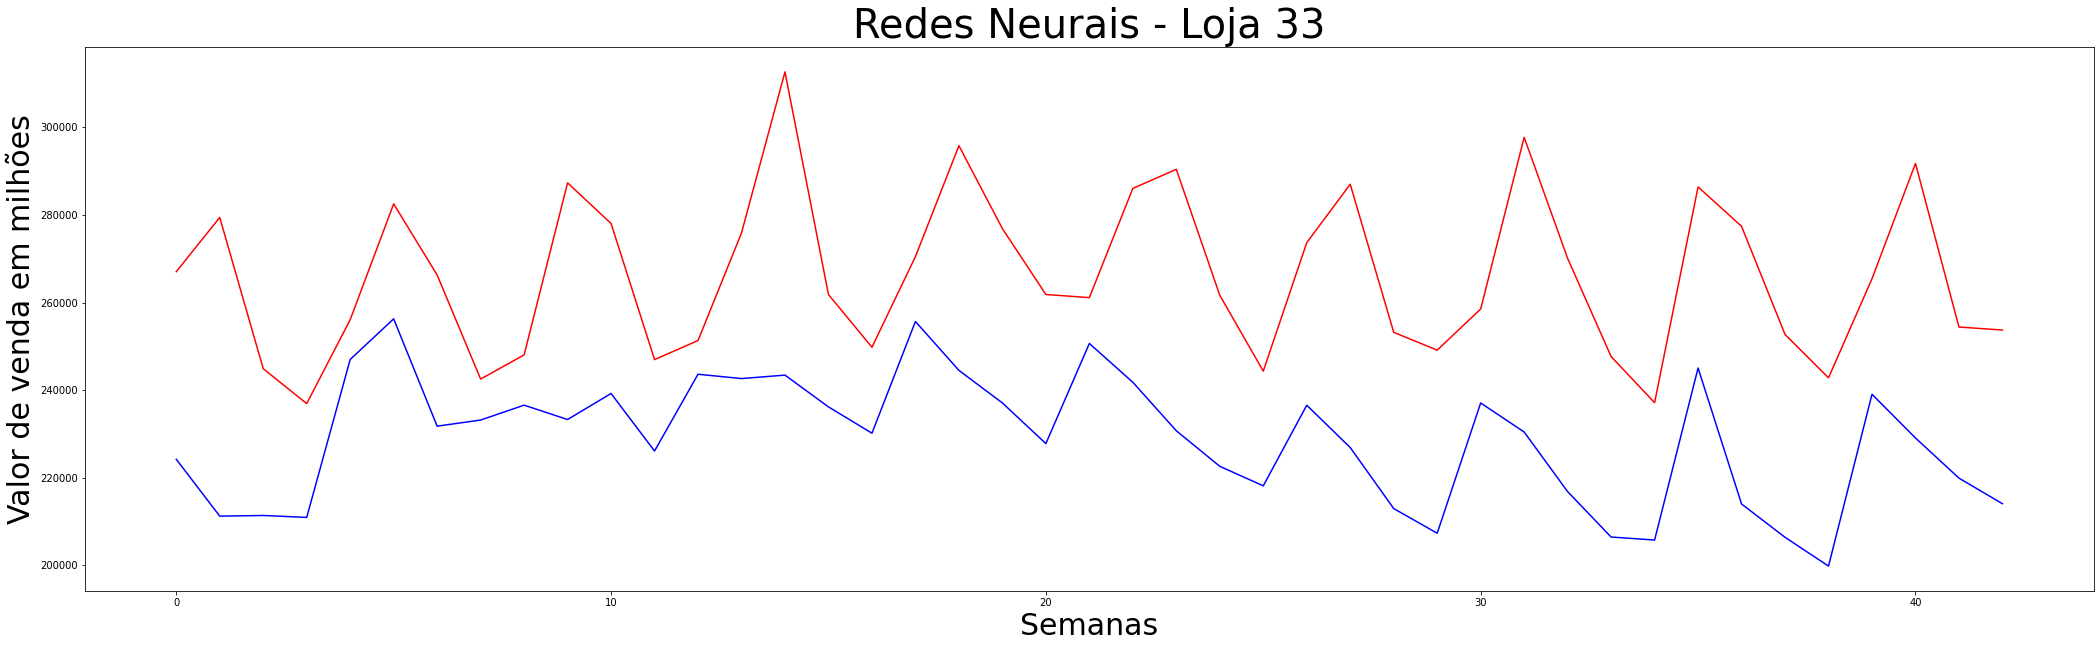

**************************************************
2/2 [==============================] - 0s 7ms/step
Resultados Loja 34:
61702.164 73876.766


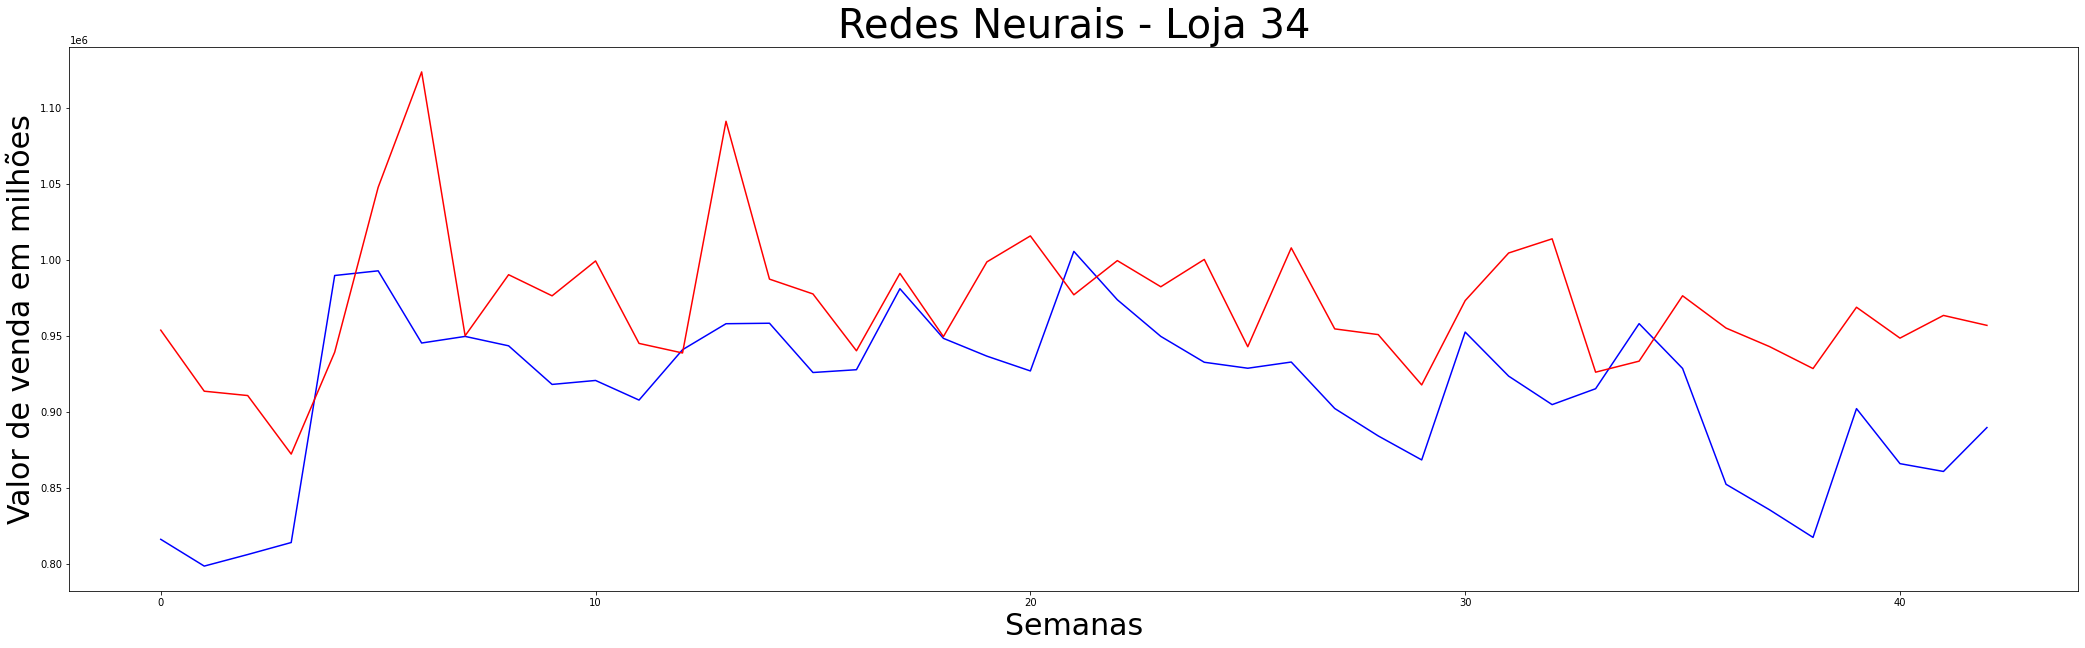

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 35:
119725.88 132029.31


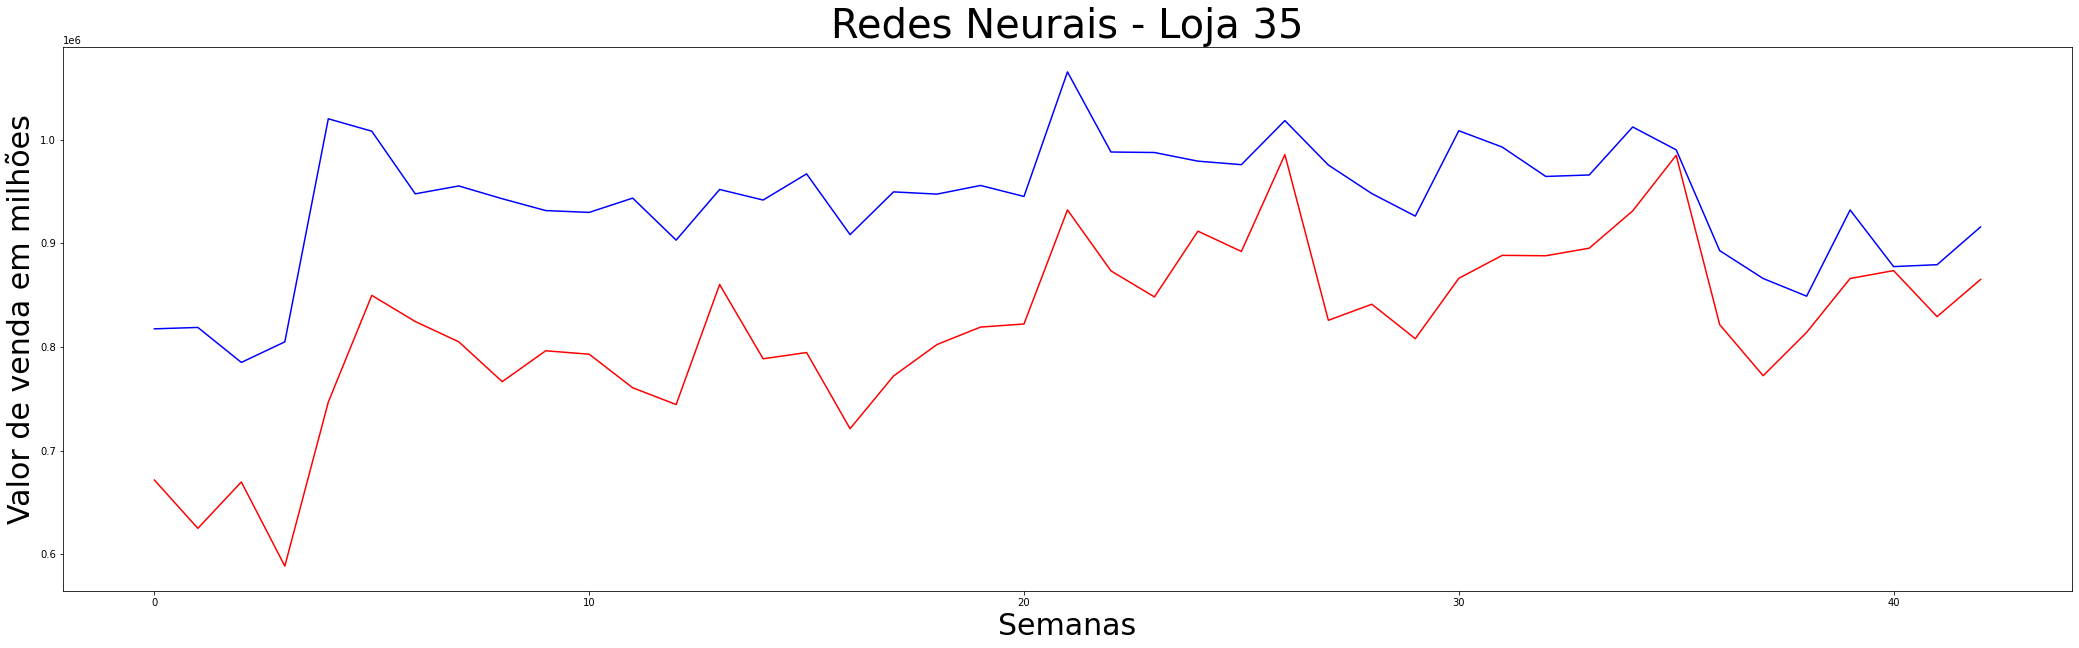

**************************************************
2/2 [==============================] - 0s 7ms/step
Resultados Loja 36:
74164.02 75700.766


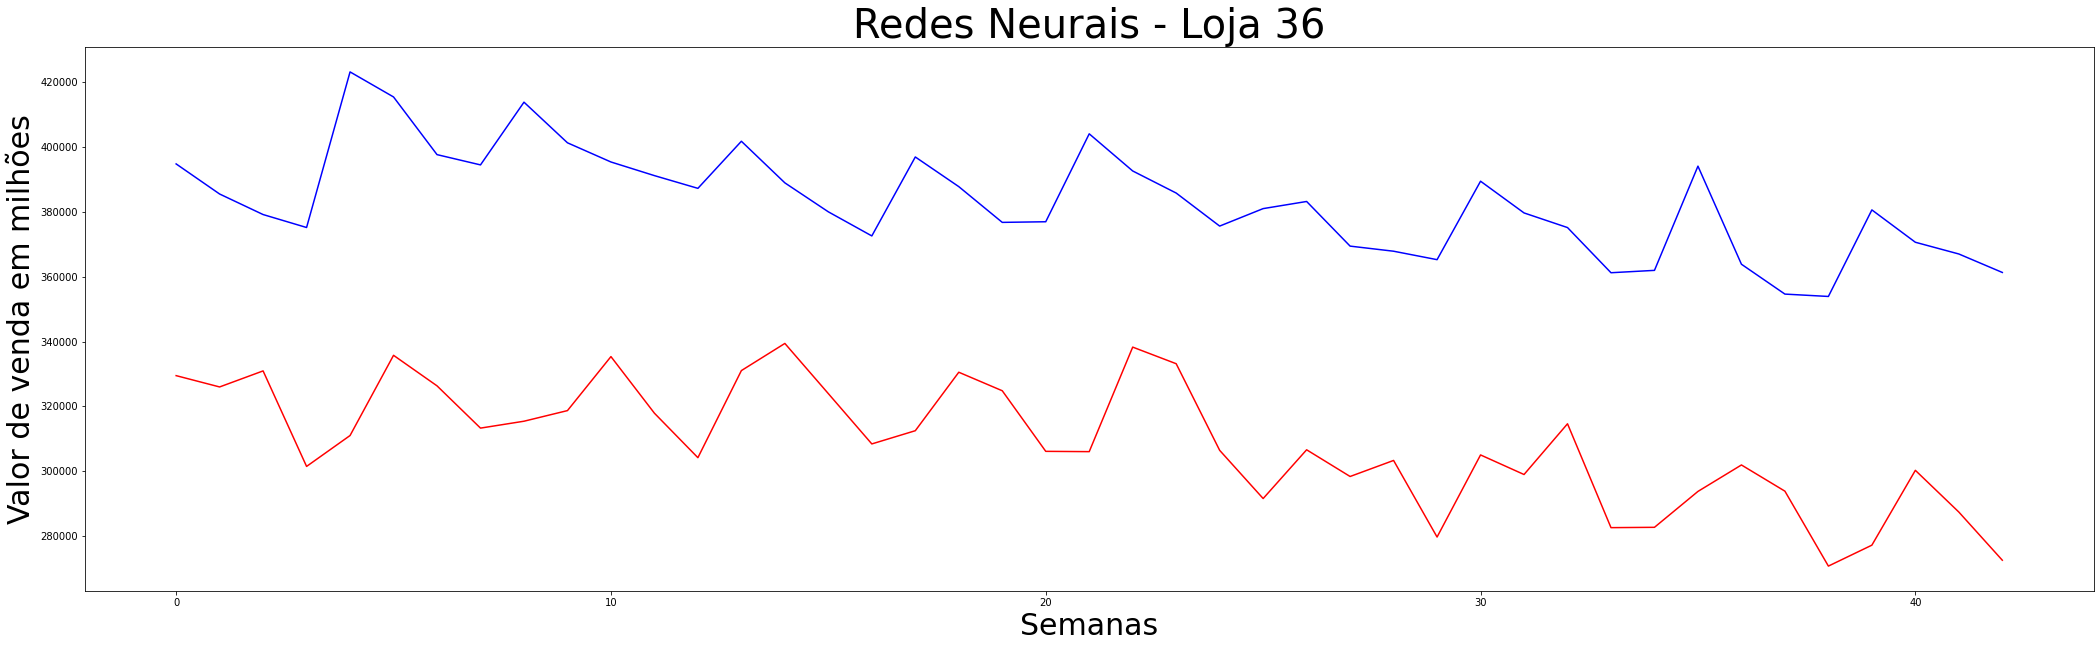

**************************************************
2/2 [==============================] - 0s 5ms/step
Resultados Loja 37:
29885.48 35271.953


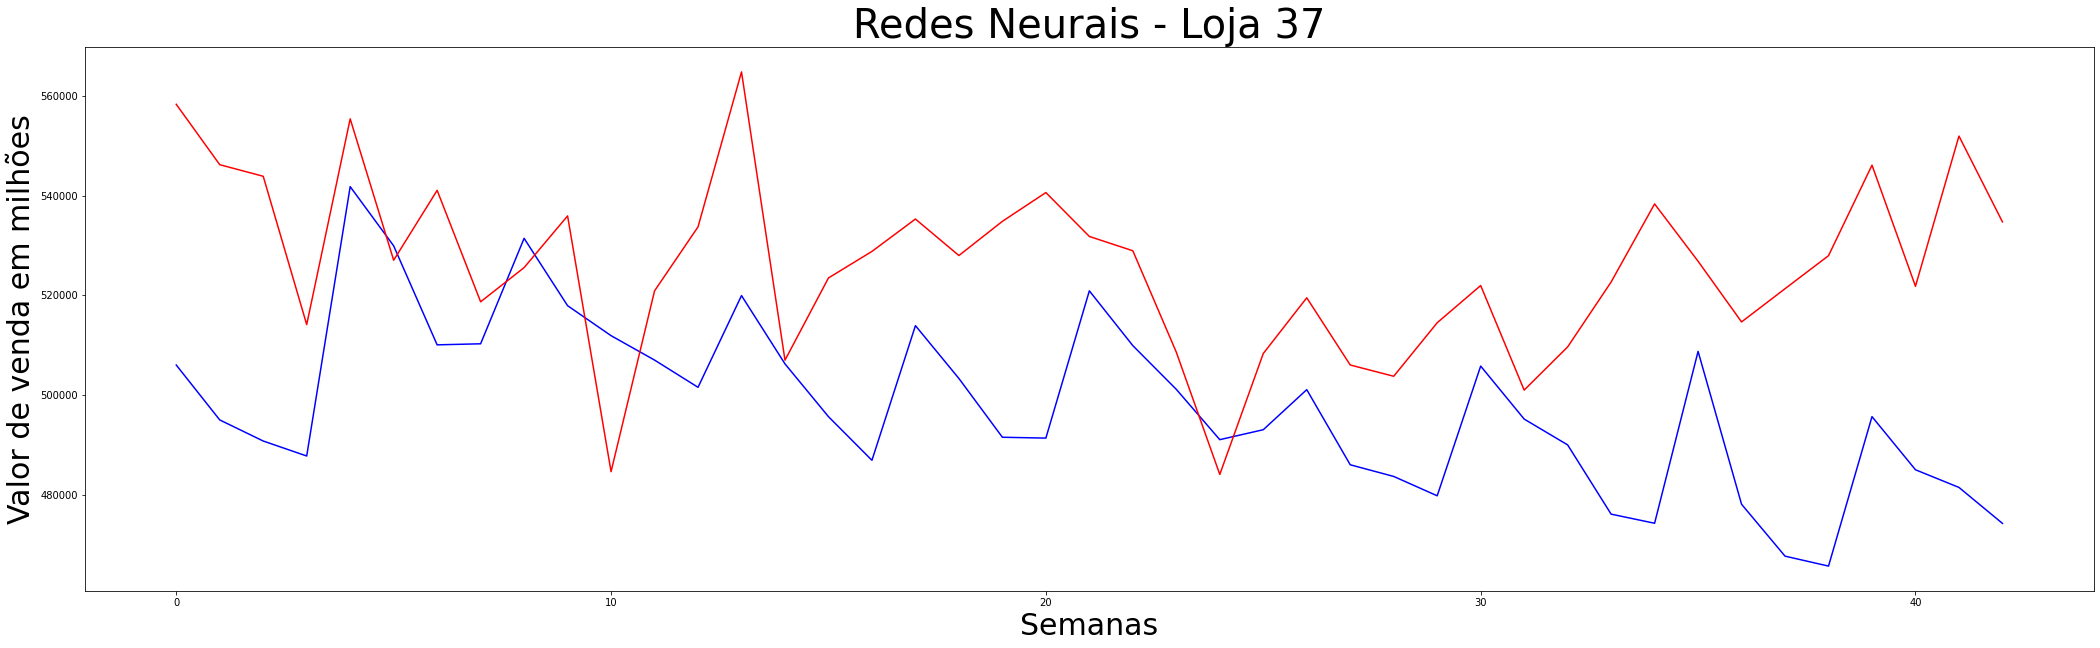

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 38:
116481.41 119046.81


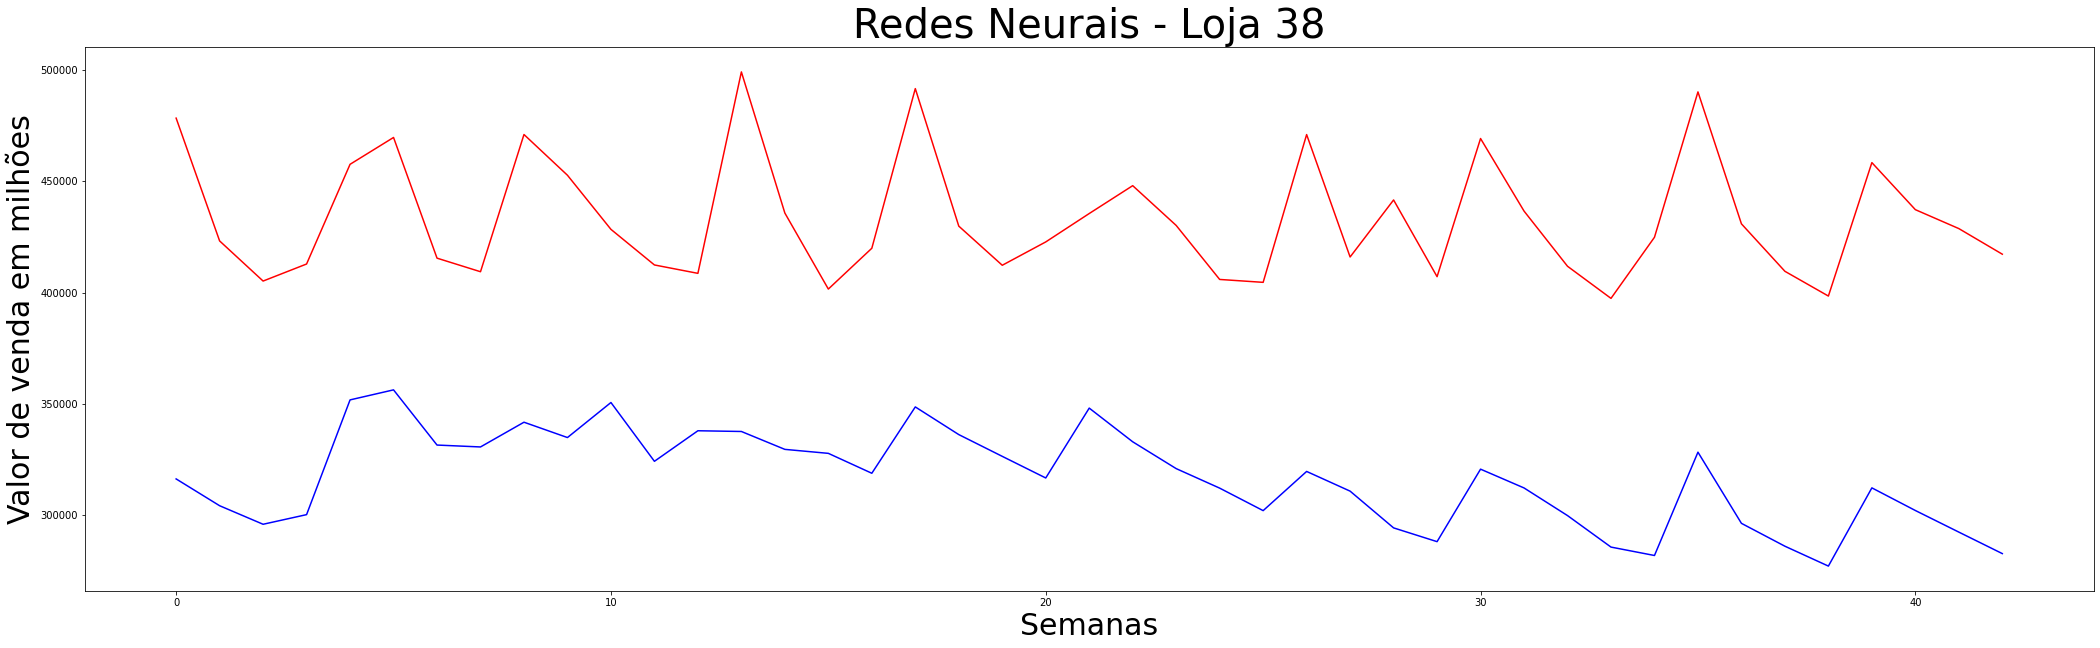

**************************************************
2/2 [==============================] - 0s 13ms/step
Resultados Loja 39:
197945.86 218654.19


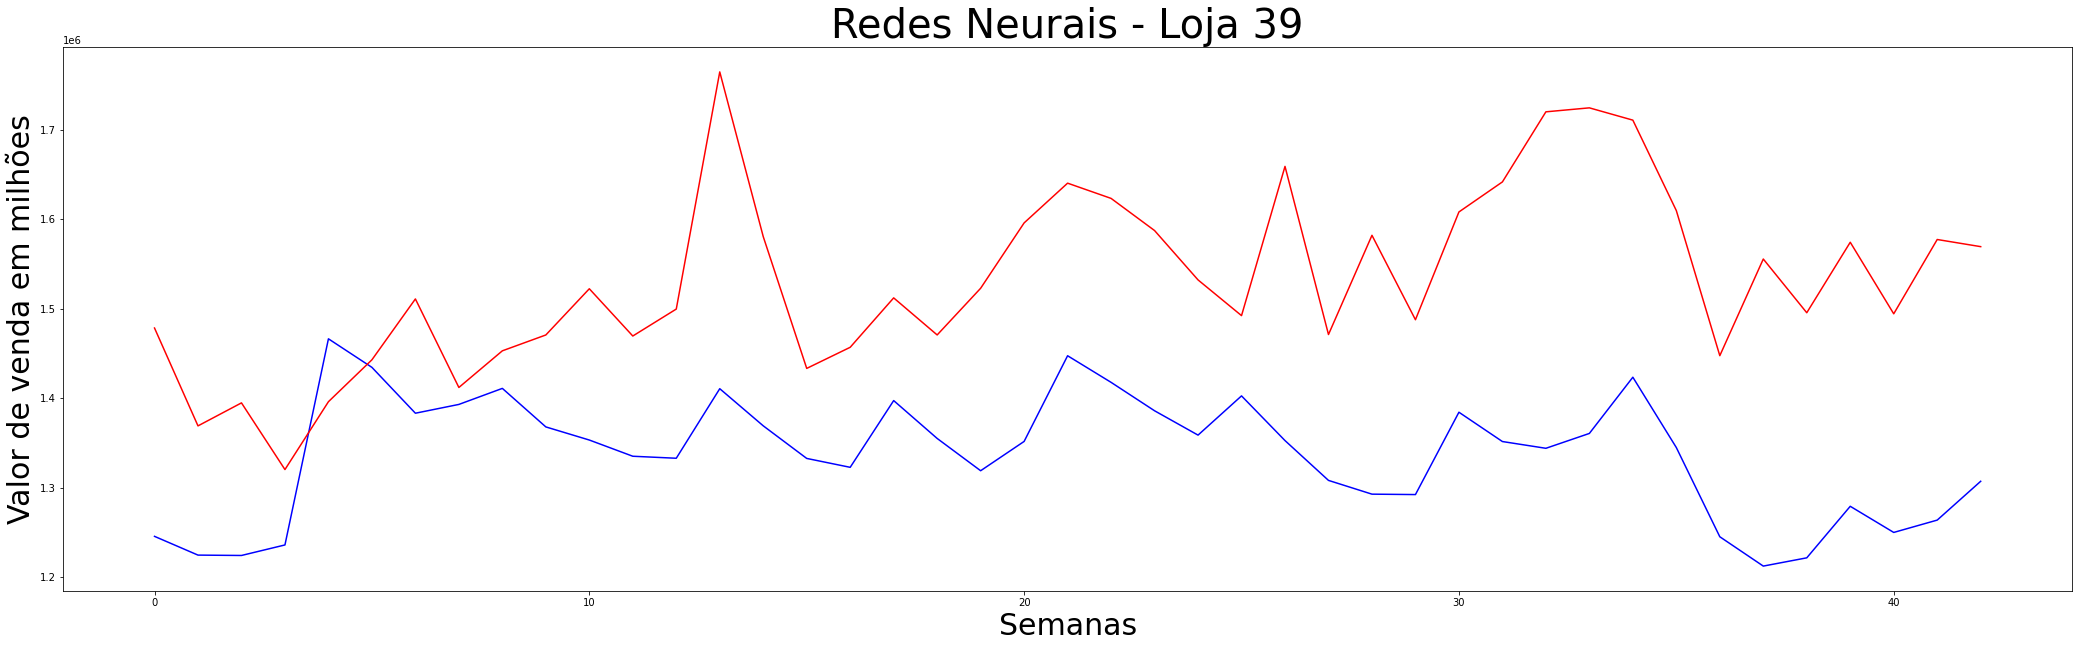

**************************************************
2/2 [==============================] - 0s 14ms/step
Resultados Loja 40:
62075.977 83435.336


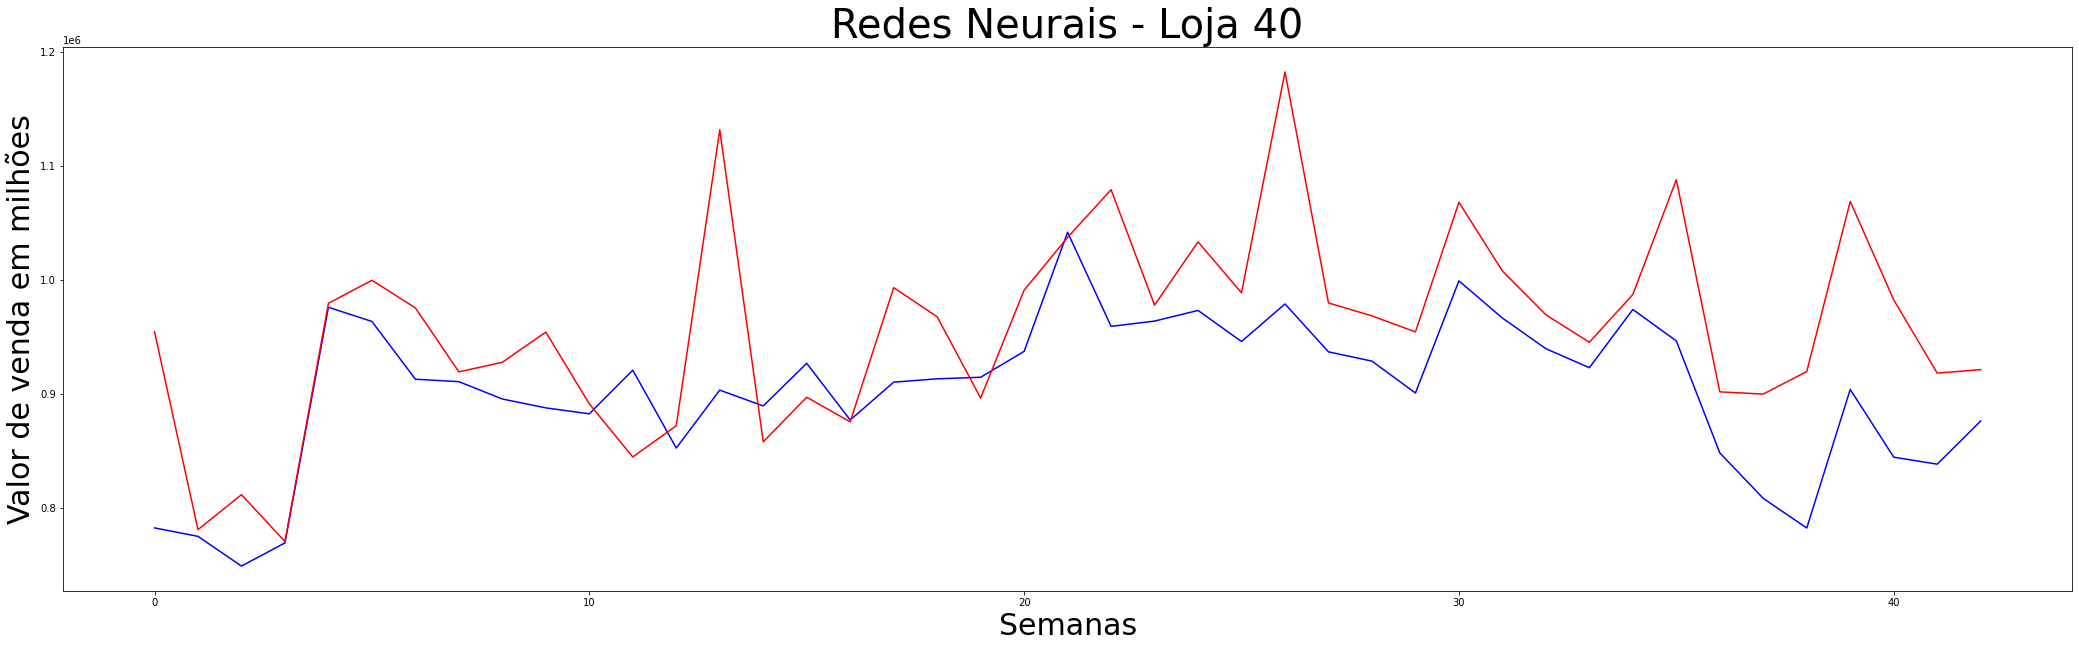

**************************************************
2/2 [==============================] - 0s 15ms/step
Resultados Loja 41:
181957.14 202608.22


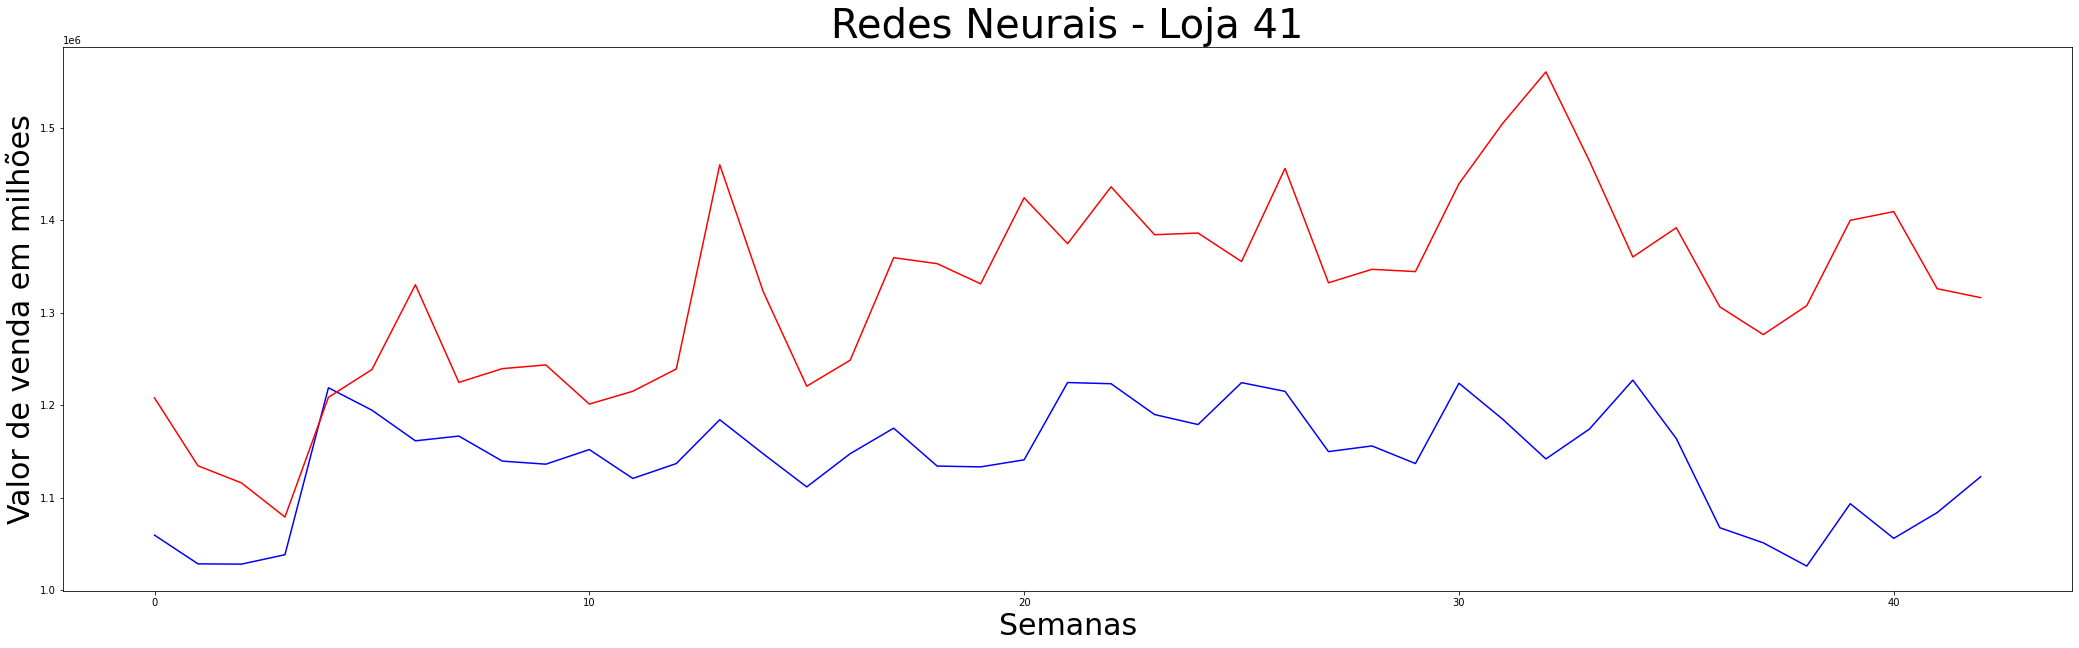

**************************************************
2/2 [==============================] - 0s 10ms/step
Resultados Loja 42:
399647.97 405234.4


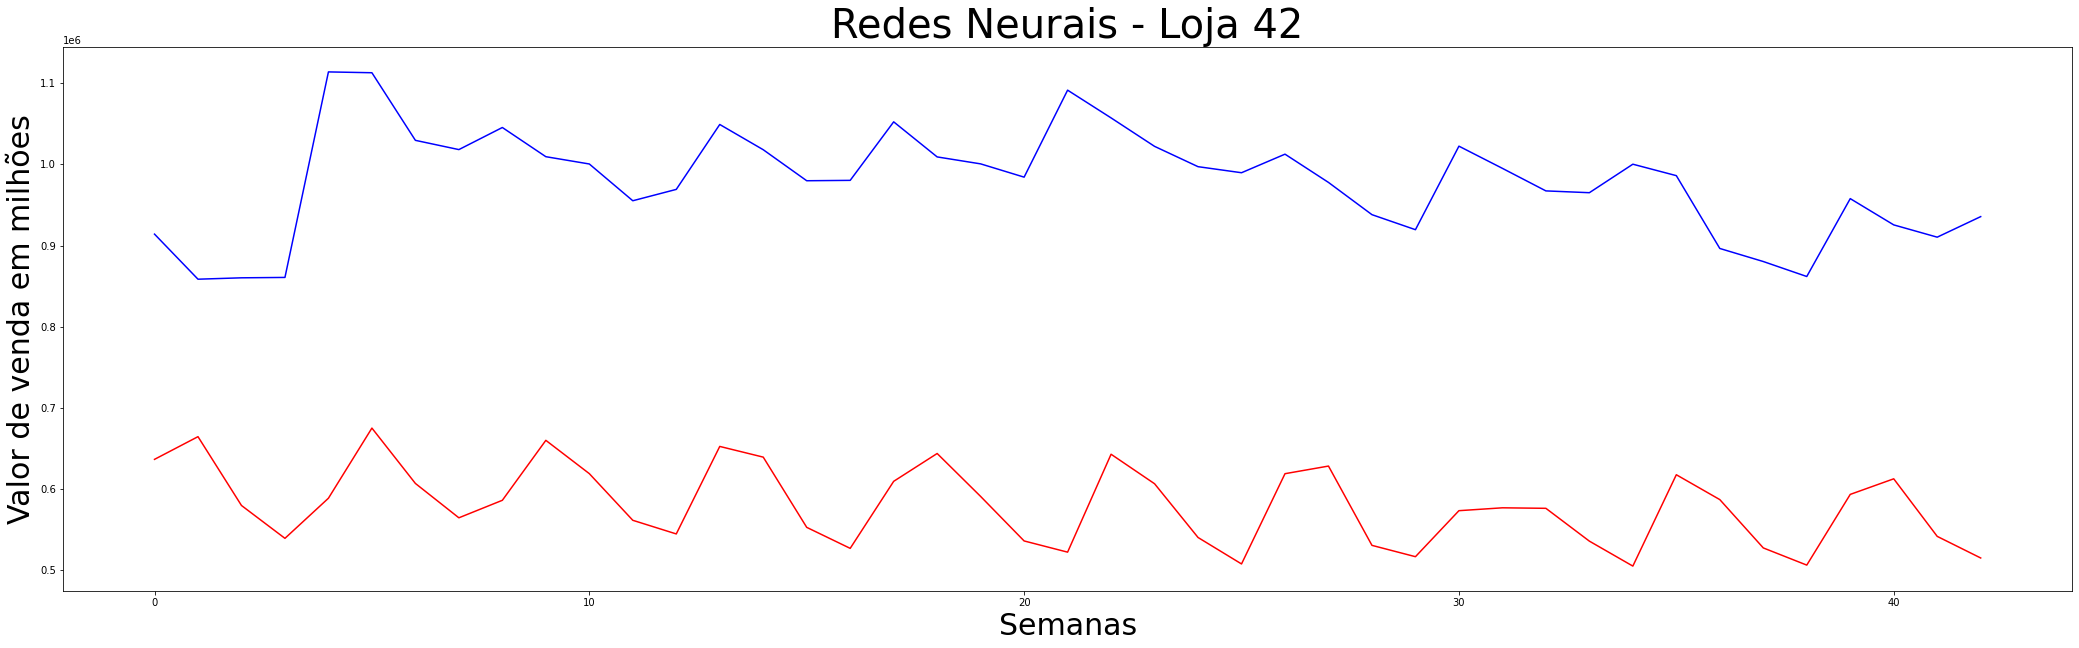

**************************************************
2/2 [==============================] - 0s 12ms/step
Resultados Loja 43:
489170.12 492824.72


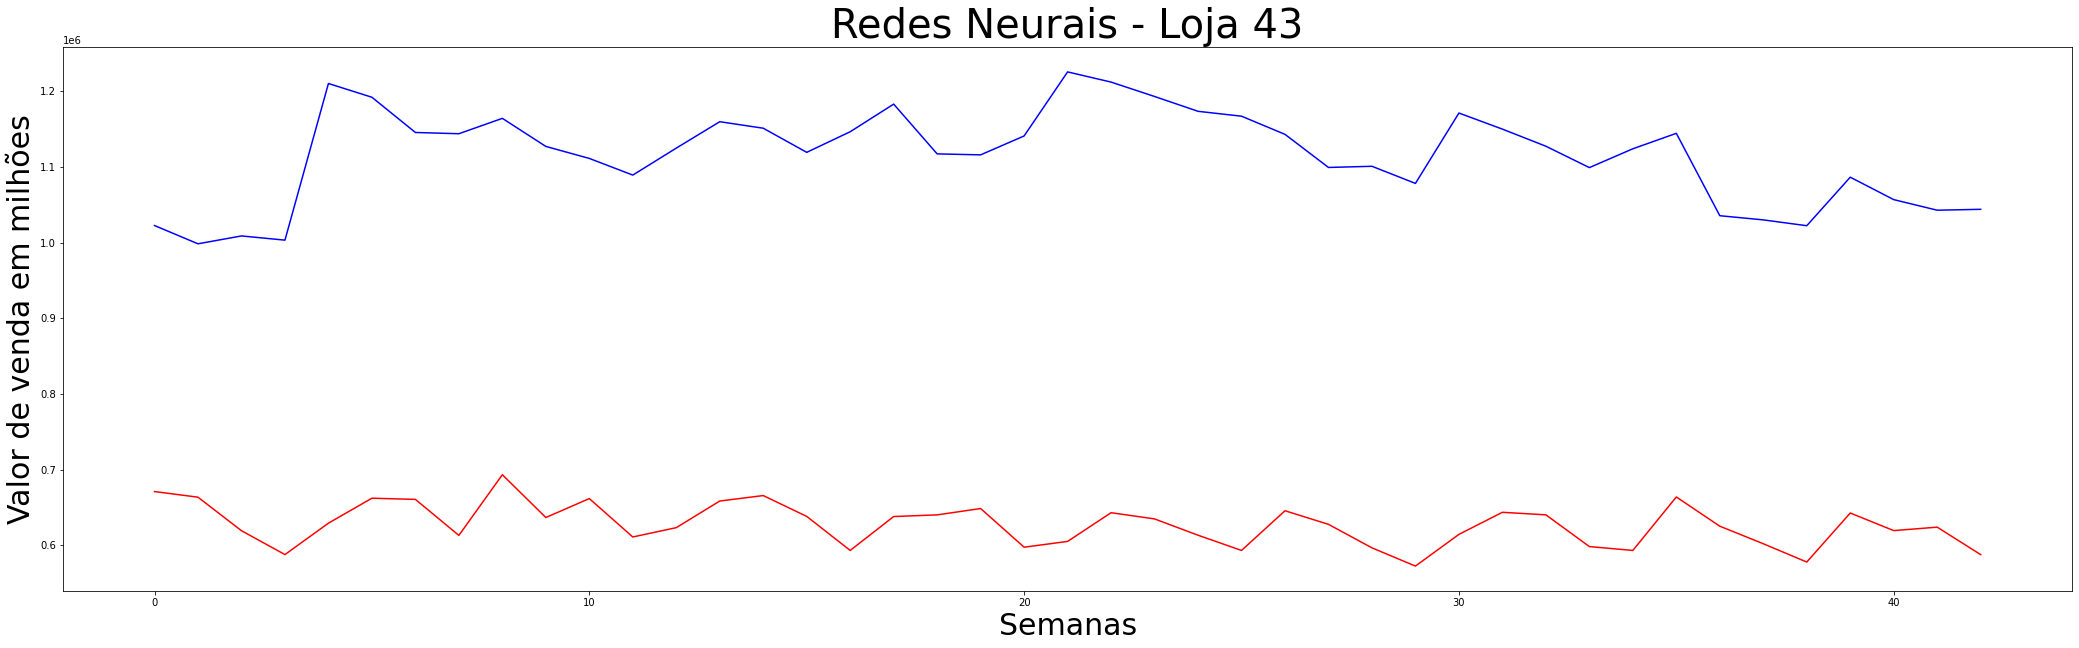

**************************************************
2/2 [==============================] - 0s 8ms/step
Resultados Loja 44:
543031.1 546181.44


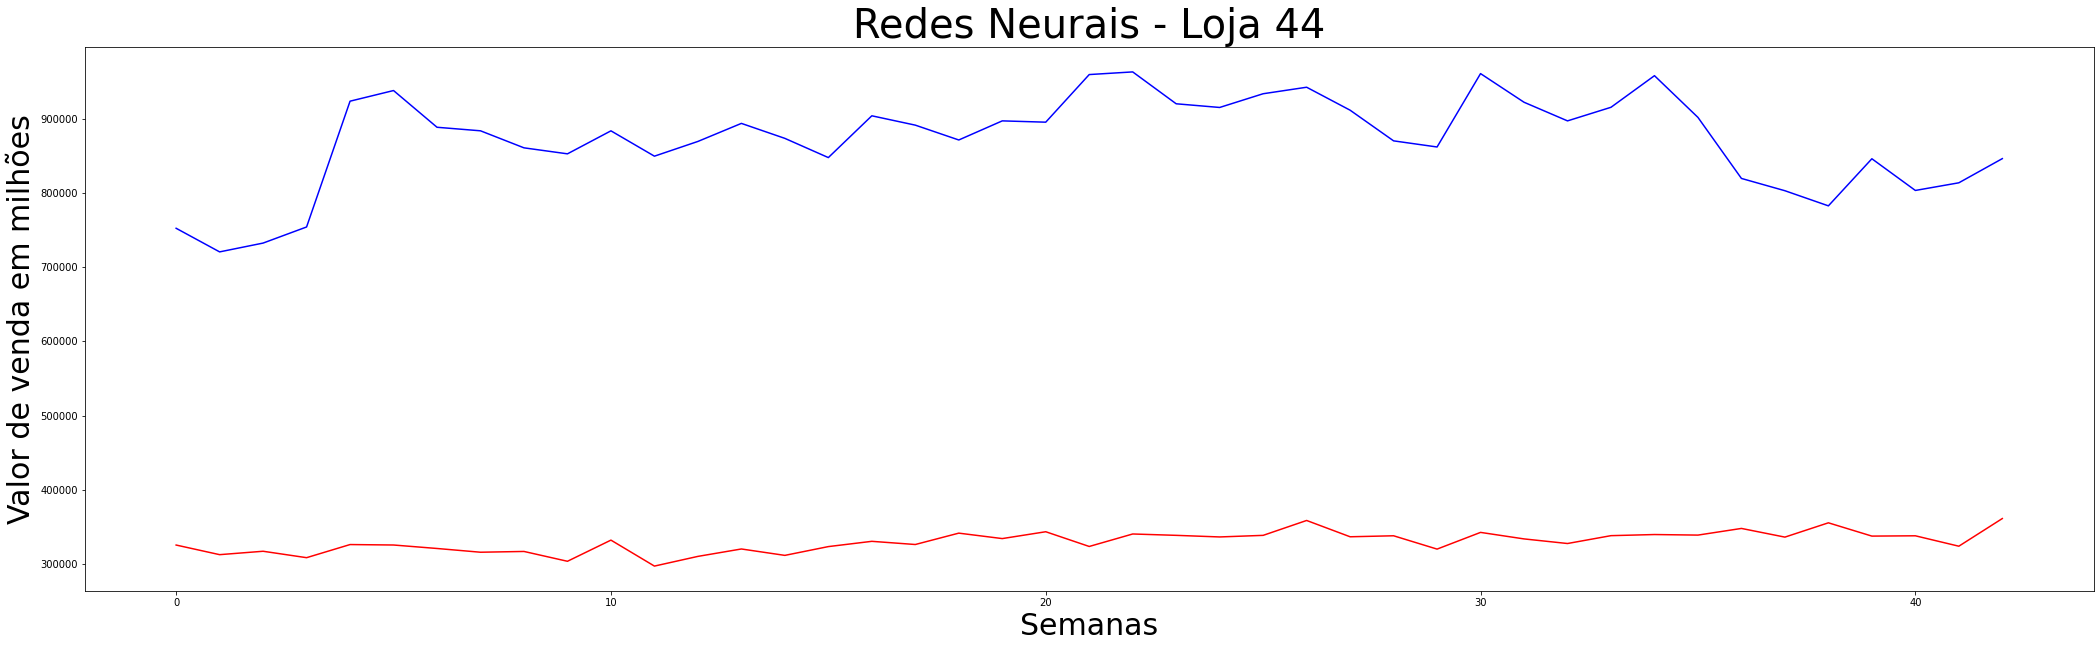

**************************************************
2/2 [==============================] - 0s 6ms/step
Resultados Loja 45:
269359.84 273490.9


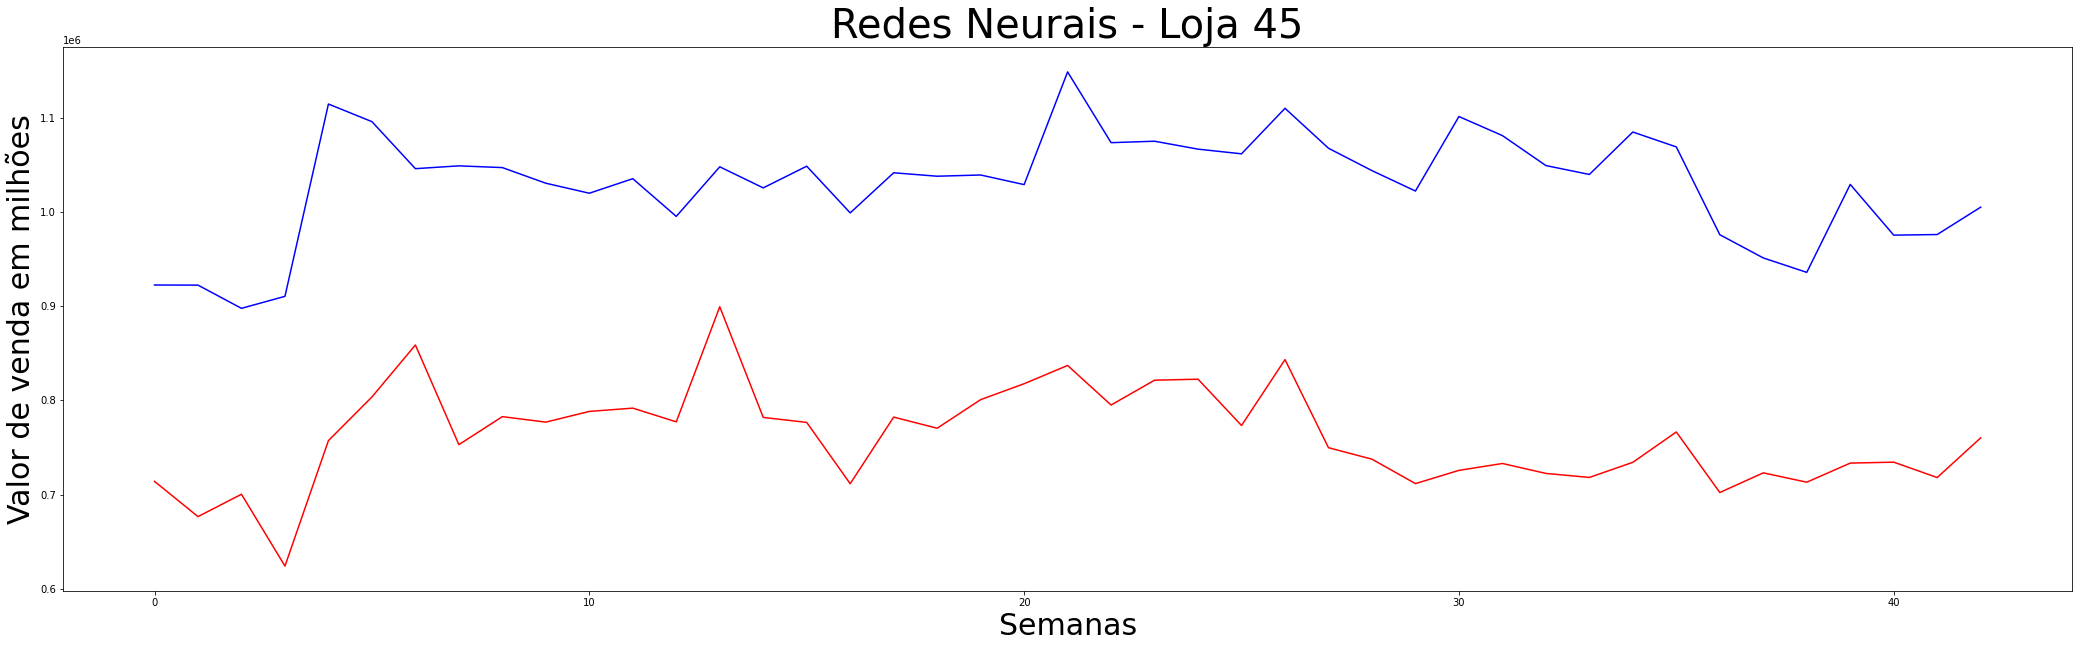

**************************************************


In [40]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = model.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Redes Neurais - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
